In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
## Copy gizmo package file from Google Drive to Colab Instance
!cp -r /content/drive/MyDrive/AC297r/gizmo/ ./gizmo

## Locally install `gizmo`
%cd gizmo
!pip install -e .

# Clone teamBlueConduit and install necessary packages and 
!git clone https://github.com/mcembalest/teamBlueConduit.git
%cd teamBlueConduit
!pip install .
!pip install -r requirements.txt > /dev/null

In [ ]:
!pip install stellargraph

#MAKE SURE TO RESTART KERNEL

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import Normalize
from matplotlib.ticker import FormatStrFormatter
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Dense

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn import preprocessing, feature_extraction, model_selection

import scipy
from scipy.sparse import csr_matrix

import stellargraph as sg
from stellargraph.mapper import GraphSAGENodeGenerator
from stellargraph.layer import GraphSAGE
from stellargraph.mapper import FullBatchNodeGenerator
from stellargraph.layer import GAT


###########
# import our libraries
from blue_conduit_spatial.utilities import *
from blue_conduit_spatial.evaluation import *
from blue_conduit_spatial.distance_matrix import *

LAT_MIN, LAT_MAX = 42.97, 43.09
LON_MIN, LON_MAX = -83.75, -83.62

########### set random state
np.random.seed(297)

# load our data

In [ ]:
data_dir = '/content/drive/MyDrive/AC297r/Data'
load_dir = f'{data_dir}/Processed'
pred_dir = f'{data_dir}/Predictions'
pid_lat_lon_path = f'{load_dir}/pid.gpkg'
train_pred_path = f'{pred_dir}/pred_probs_train.npz'
test_pred_path = f'{pred_dir}/pred_probs_test.npz'

Xdata, Ydata, location, train_pid_all, test_pid_all, partitions_builder = load_datasets(load_dir)
train_pred_all, test_pred_all = load_predictions(pred_dir, 'baseline')

In [ ]:
# load distance data
# this part is slow
dis_path = f'{load_dir}/road_distances.npz'
distances = np.load(dis_path, allow_pickle=True)

graph = distances['road_distances']
graph[graph==(1.00e+05)]=0.0 #assign invalid 1e5 values to be 0

##Invert distances
invert = lambda x: 1 / (1 + x)
graph = invert(graph)
graph[graph==(1.0)]=0.0

print('graph', graph.shape)

graph (26857, 26857)


In [ ]:
Xdata

,Homestead Percent,HomeSEV,Land Value,Land Improvements Value,Residential Building Value,Commercial Building Value,Parcel Acres,Year Built,SL_Lead,Ed_July,Ed_March,Max_Lead,Med_Lead,Num_Tests,Res_Test,Sen_Test,B_median_age_all_women,B_median_age_all_men,B_median_age_all,B_median_age_all_women_white,B_median_age_all_men_white,B_median_age_all_white,B_median_age_all_women_black,B_median_age_all_men_black,B_median_age_all_black,B_total_black_pop,B_total_white_pop,B_married_couples,B_single_women,B_married_couples_white,B_single_women_white,B_married_couples_black,B_single_women_black,B_married_couples_w_children,B_single_mothers_w_children,B_households_w_elderly,B_househod_no_elderly,B_aggregate_income,B_speak_spanish,B_speak_only_english,...,CENTRACT_600,CENTRACT_700,CENTRACT_800,CENTRACT_900,CENTRACT_1000,CENTRACT_1100,CENTRACT_1200,CENTRACT_1300,CENTRACT_1400,CENTRACT_1500,CENTRACT_1600,CENTRACT_1700,CENTRACT_1800,CENTRACT_1900,CENTRACT_2000,CENTRACT_2200,CENTRACT_2300,CENTRACT_2400,CENTRACT_2600,CENTRACT_2700,CENTRACT_2800,CENTRACT_2900,CENTRACT_3000,CENTRACT_3100,CENTRACT_3200,CENTRACT_3300,CENTRACT_3400,CENTRACT_3500,CENTRACT_3600,CENTRACT_3700,CENTRACT_3800,CENTRACT_4000,CENTRACT_13500,CENTRACT_13600,CENBLOCK_1,CENBLOCK_2,CENBLOCK_3,CENBLOCK_4,CENBLOCK_5,CENBLOCK_6
pid,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
4012482018,100.0,18400,932,0,35843,0.0,0.140,2,0,0.0,0.0,-1.0,-1.0,0.0,0.0,0.0,24.5,33.4,29.1,36.5,34.4,34.4,23.5,34.6,23.8,782,448,98,75,7,2,83,73,18,64,79,374,6293700.0,19,805,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
4013226009,100.0,11800,420,0,23227,0.0,0.050,2,0,0.0,0.0,-1.0,-1.0,0.0,0.0,0.0,24.5,33.4,29.1,36.5,34.4,34.4,23.5,34.6,23.8,782,448,98,75,7,2,83,73,18,64,79,374,6293700.0,19,805,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
4012476011,0.0,0,602,0,18180,0.0,0.051,1912,0,0.0,0.0,-1.0,-1.0,0.0,0.0,0.0,24.5,33.4,29.1,36.5,34.4,34.4,23.5,34.6,23.8,782,448,98,75,7,2,83,73,18,64,79,374,6293700.0,19,805,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
4012481022,50.0,4550,781,0,17452,0.0,0.086,2,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,24.5,33.4,29.1,36.5,34.4,34.4,23.5,34.6,23.8,782,448,98,75,7,2,83,73,18,64,79,374,6293700.0,19,805,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
4013226025,100.0,12800,510,0,25104,0.0,0.070,1900,0,0.0,0.0,4.0,0.0,1.0,1.0,0.0,24.5,33.4,29.1,36.5,34.4,34.4,23.5,34.6,23.8,782,448,98,75,7,2,83,73,18,64,79,374,6293700.0,19,805,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4002378026,100.0,19100,4291,0,111597,0.0,0.391,1928,0,0.0,0.0,-1.0,-1.0,0.0,0.0,0.0,43.4,54.9,45.2,-1.0,76.5,73.5,43.6,54.3,43.8,510,26,45,60,12,0,33,60,7,19,75,189,-1.0,0,649,...,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
4002459029,100.0,20900,2557,0,171345,0.0,0.222,1948,1,0.0,0.0,-1.0,-1.0,0.0,0.0,0.0,43.4,54.9,45.2,-1.0,76.5,73.5,43.6,54.3,43.8,510,26,45,60,12,0,33,60,7,19,75,189,-1.0,0,649,...,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
4002378013,100.0,0,2651,717,81145,0.0,0.239,1925,0,0.0,0.0,-1.0,-1.0,0.0,0.0,0.0,43.4,54.9,45.2,-1.0,76.5,73.5,43.6,54.3,43.8,510,26,45,60,12,0,33,60,7,19,75,189,-1.0,0,649,...,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


In [ ]:
def get_xgboost_prob(train_pred, test_pred, train_mask, test_mask, train_index, test_index, idx):
  '''
  Args:
    train_pred: 
    test_pred:
    train_mask:
    test_mask:
    train_index:
    test_index:
    idx: the index according to the original 0,...,26856 list
  Returns:
    res: float, the XGBoost probability of lead at this home (either from train_pred or test_pred)
  '''

  try:
    res = None
    if train_mask[idx]:
      res =  train_pred[np.where(train_index==idx)][0]
    elif test_mask[idx]:
      res = test_pred[np.where(test_index==idx)][0]
    return res
  except BaseException as err:
    print(train_pred.shape, test_pred.shape, train_mask.shape, test_mask_shape)
    raise

def get_fts(Xtrain, Xtest, train_pid, test_pid, train_mask, test_mask, train_index, test_index, idx):
  '''
  Args:
    Xtrain:
    Xtest:
    train_mask:
    test_mask:
    train_index:
    test_index:
    idx: the index according to the original 0,...,26856 list
  Returns:
    res: 
  '''

  try:
    res = None
    if train_mask[idx]:
      res =  Xtrain.loc[train_pid[np.where(train_index==idx)]]#train_pred[np.where(train_index==idx)][0]
    elif test_mask[idx]:
      res = Xtest.loc[test_pid[np.where(test_index==idx)]]#test_pred[np.where(test_index==idx)][0]
    return res.values.flatten()
  except BaseException as err:
    print(Xtrain.shape, Xtest.shape, train_mask.shape, test_mask_shape)
    raise

def get_trained_graphSAGE_for_experiment(train_size, hex_size, s, include_xgboost=False, verbose=False):
  '''
  Args:
    train_size:
    hex_size:
    s:
    verbose:

  Returns:
    flint_graphSAGE:
    flint_graphSAGE_train_gen:
    flint_graphSAGE_test_gen:
  '''
  print(train_size, hex_size, s)

  # PARAMS
  batch_size = 256
  num_neighbor_samples = [15,10]
  hidden_layer_size = [64,64]
  dropout_pct = 0.5
  train_lr = 1e-1
  train_n_epochs = 20



  train_pid = train_pid_all[f'ts_{train_size}'][f'res_{hex_size}'][s]
  test_pid = test_pid_all[f'ts_{train_size}'][f'res_{hex_size}'][s]

  Xtrain = Xdata.loc[train_pid]
  Xtest = Xdata.loc[test_pid]
  Ytrain = Ydata.loc[train_pid]['dangerous'].values.astype('float')
  Ytest = Ydata.loc[test_pid]['dangerous'].values.astype('float')
  train_pred = train_pred_all[f'ts_{train_size}'][f'res_{hex_size}'][s]
  test_pred = test_pred_all[f'ts_{train_size}'][f'res_{hex_size}'][s]
  # pid_lat_lon_train = location.loc[train_pid]
  # pid_lat_lon_test = location.loc[test_pid]
  location['orig_index'] = np.arange(location.shape[0])
  train_index = location.loc[train_pid, 'orig_index'].values
  test_index = location.loc[test_pid, 'orig_index'].values

  ## build subgraph
  subgraph_idx = np.array([i for i in range(len(Ydata)) if (i in train_index or i in test_index)])
  n_subgraph = len(subgraph_idx)
  subgraph = graph[:,subgraph_idx][subgraph_idx,:]

  # build graph edges
  sparse_subgraph = csr_matrix(subgraph)
  row_idx, col_idx, vals = scipy.sparse.find(sparse_subgraph)
  edges = np.vstack([subgraph_idx[col_idx], subgraph_idx[row_idx]]).T.astype('float32')





  ########################
  scaler = preprocessing.StandardScaler()
  Xdata_scaled_train = scaler.fit_transform(Xdata.loc[train_pid])
  Xdata_scaled_test = scaler.transform(Xdata.loc[test_pid])

  Xdata_scaled = Xdata.copy()
  Xdata_scaled.loc[train_pid] = Xdata_scaled_train
  Xdata_scaled.loc[test_pid] = Xdata_scaled_test

  train_mask = np.array([1 if i in train_index else 0 for i in range(len(Ydata))])
  test_mask = np.array([1 if i in test_index else 0 for i in range(len(Ydata))])

  if verbose:
    print('built scaled data and masks')
  train_indices = np.array([idx for idx in subgraph_idx if train_mask[idx]]).astype('int32')
  train_labels = np.array([Ydata.dangerous.values[idx] for idx in subgraph_idx if train_mask[idx]])
  test_indices = np.array([idx for idx in subgraph_idx if test_mask[idx]]).astype('int32')
  test_labels = np.array([Ydata.dangerous.values[idx] for idx in subgraph_idx if test_mask[idx]])

  # build graph features
  chosen_features = Xdata.columns
  fts = np.array([get_fts(Xtrain, Xtest, train_pid, test_pid, train_mask, test_mask, train_index, test_index, idx) for idx in subgraph_idx])

  if include_xgboost:
    fts = np.hstack([np.array([get_xgboost_prob(train_pred, test_pred, train_mask, test_mask, train_index, test_index, idx) for idx in subgraph_idx]).reshape(-1,1), fts])
  #print(fts.shape)
  #assert 0==1
  ## stellargraph object
  flint_train_labels_series = pd.Series(data=train_labels,index=train_indices)
  flint_test_labels_series = pd.Series(data=test_labels,index=test_indices)

  flint_node_data = pd.DataFrame(
      {f : fts[:,i] for i, f in enumerate(chosen_features)}, index=subgraph_idx.astype('int64')
  )
  flint_edge_data = pd.DataFrame({"source": edges[:,0].astype('int64'), "target": edges[:,1].astype('int64')})
  flint_G = sg.StellarGraph(flint_node_data, flint_edge_data)
  #####################




  if verbose:
    print('built graph')

  ## GraphSAGE#####################

  generator = GraphSAGENodeGenerator(flint_G, batch_size, num_neighbor_samples)

  target_encoding = preprocessing.LabelBinarizer()
  train_targets = target_encoding.fit_transform(flint_train_labels_series)
  test_targets = target_encoding.transform(flint_test_labels_series)
  flint_graphSAGE_train_gen = generator.flow(flint_train_labels_series.index, train_targets)
  flint_graphSAGE_test_gen = generator.flow(flint_test_labels_series.index, test_targets)

  graphsage_model = GraphSAGE(
    layer_sizes=hidden_layer_size, generator=generator, bias=True, dropout=dropout_pct,
  )

  x_inp, x_out = graphsage_model.in_out_tensors()
  prediction = layers.Dense(units=train_targets.shape[1], activation="sigmoid")(x_out)

  flint_graphSAGE = Model(inputs=x_inp, outputs=prediction)

  if verbose:
    print('built model')
  #################







  # pretraining
  ##################
  flint_graphSAGE.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=train_lr),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=[tf.keras.metrics.BinaryAccuracy(name='acc'), tf.keras.metrics.Precision(name='prec'), tf.keras.metrics.Recall(name='rec')]
  )

  flint_graphSAGE.fit(
      flint_graphSAGE_train_gen,
      epochs=train_n_epochs,
      verbose={True: 2, False: 0}[verbose],
      shuffle=True,
  )
  
  ##################

  return flint_graphSAGE, flint_graphSAGE_train_gen, flint_graphSAGE_test_gen 

def train_models_on_data_splits(GraphSAGE_train_preds, GraphSAGE_test_preds, train_sizes, splits, resolutions, include_xgboost=False, verbose=False):
  '''
  Args:
    GraphSAGE_train_preds:  
    GraphSAGE_test_preds:

    train_sizes:
    splits:
    resolutions:

  Returns:
    GraphSAGE_train_preds
    GraphSAGE_test_preds
  '''
  for train_size in train_sizes:

    for hex_size in resolutions:
      train_preds= []
      test_preds =[]
      for s in splits:
        flint_graphSAGE, flint_graphSAGE_train_gen, flint_graphSAGE_test_gen = get_trained_graphSAGE_for_experiment(train_size, hex_size, s, include_xgboost=include_xgboost, verbose=verbose)

        y_pred_train_graphSAGE = flint_graphSAGE.predict(flint_graphSAGE_train_gen).flatten()
        y_pred_test_graphSAGE = flint_graphSAGE.predict(flint_graphSAGE_test_gen).flatten()

        train_preds.append(y_pred_train_graphSAGE)
        test_preds.append(y_pred_test_graphSAGE)
      
      GraphSAGE_train_preds[f'ts_{train_size}'][f'res_{hex_size}'] = np.array(train_preds)
      GraphSAGE_test_preds[f'ts_{train_size}'][f'res_{hex_size}'] = np.array(test_preds)

  return GraphSAGE_train_preds, GraphSAGE_test_preds

def save_GraphSAGE_model_predictions(GraphSAGE_results):
  GraphSAGE_train_preds, GraphSAGE_test_preds= GraphSAGE_results
  np.savez(f'{pred_dir}/GraphSAGE_pred_probs_train.npz', **GraphSAGE_train_preds)
  np.savez(f'{pred_dir}/GraphSAGE_pred_probs_test.npz', **GraphSAGE_test_preds)


In [ ]:
#flint_graphSAGE, flint_graphSAGE_train_gen, flint_graphSAGE_test_gen = get_trained_graphSAGE_for_experiment(0.3, 99, 0, verbose=True)


In [ ]:
helpedflint_graphSAGE, helpedflint_graphSAGE_train_gen, helpedflint_graphSAGE_test_gen = get_trained_graphSAGE_for_experiment(0.3, 99, 0, include_xgboost=True, verbose=True)


0.3 99 0
built scaled data and masks
built graph
built model
Epoch 1/20
19/19 - 6s - loss: 0.6688 - acc: 0.5763 - prec: 0.3715 - rec: 0.1611 - 6s/epoch - 314ms/step
Epoch 2/20
19/19 - 4s - loss: 0.6547 - acc: 0.5981 - prec: 0.4000 - rec: 0.1082 - 4s/epoch - 236ms/step
Epoch 3/20
19/19 - 4s - loss: 0.6540 - acc: 0.6030 - prec: 0.3973 - rec: 0.0800 - 4s/epoch - 233ms/step
Epoch 4/20
19/19 - 4s - loss: 0.6798 - acc: 0.5786 - prec: 0.4305 - rec: 0.3267 - 4s/epoch - 232ms/step
Epoch 5/20
19/19 - 4s - loss: 0.6458 - acc: 0.5948 - prec: 0.3933 - rec: 0.1159 - 4s/epoch - 236ms/step
Epoch 6/20
19/19 - 4s - loss: 0.6537 - acc: 0.5927 - prec: 0.4338 - rec: 0.2241 - 4s/epoch - 232ms/step
Epoch 7/20
19/19 - 4s - loss: 0.6363 - acc: 0.6249 - prec: 0.5475 - rec: 0.0922 - 4s/epoch - 235ms/step
Epoch 8/20
19/19 - 4s - loss: 0.6389 - acc: 0.6223 - prec: 0.5339 - rec: 0.0740 - 4s/epoch - 229ms/step
Epoch 9/20
19/19 - 4s - loss: 0.6392 - acc: 0.6072 - prec: 0.4706 - rec: 0.2428 - 4s/epoch - 229ms/step
Epo

In [ ]:
train_size, hex_size, s = 0.3, 99, 0
train_pid = train_pid_all[f'ts_{train_size}'][f'res_{hex_size}'][s]
test_pid = test_pid_all[f'ts_{train_size}'][f'res_{hex_size}'][s]

Xtrain = Xdata.loc[train_pid]
Xtest = Xdata.loc[test_pid]
Ytrain = Ydata.loc[train_pid]['dangerous'].values.astype('float')
Ytest = Ydata.loc[test_pid]['dangerous'].values.astype('float')
train_pred = train_pred_all[f'ts_{train_size}'][f'res_{hex_size}'][s]
test_pred = test_pred_all[f'ts_{train_size}'][f'res_{hex_size}'][s]

location['orig_index'] = np.arange(location.shape[0])
train_index = location.loc[train_pid, 'orig_index'].values
test_index = location.loc[test_pid, 'orig_index'].values
hexagons = partitions_builder.Partition(partition_type='hexagon', num_cells_across=hex_size)



2021-11-19 21:17.27 [info     ] Generating the partition map of type 'hexagon'


100%|██████████| 4828/4828 [00:00<00:00, 16989.08it/s]


2021-11-19 21:17.30 [info     ] Tesselate() is performing gpd.sjoin() to remove partitions that contain no parcels.
2021-11-19 21:17.30 [info     ] Building the partition-parcel lookup table with add_partition_ID_via_sjoin()


/content/teamBlueConduit/gizmo/gizmo/spatial_partitions/partitions.py:116: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  **kwargs,


2021-11-19 21:17.34 [debug    ] Total parcels after join: 26857
2021-11-19 21:17.34 [info     ] Building the connected graph on the partitions.
2021-11-19 21:17.56 [info     ] New Partition dataframe of type 'hexagon' created, using at least 10.95 MB of memory


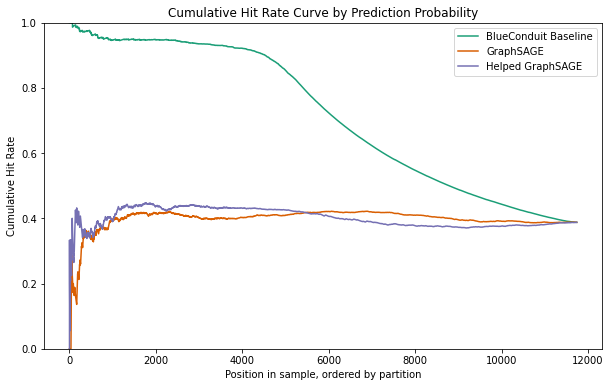

In [ ]:
ypred1 = flint_graphSAGE.predict(flint_graphSAGE_test_gen)
ypred2 = helpedflint_graphSAGE.predict(helpedflint_graphSAGE_test_gen)

mod_train_list = [test_pred, ypred1, ypred2]

plot_hit_rate_curve(Ytest, mod_train_list, plot_probs=False, labels=['BlueConduit Baseline', 'GraphSAGE', 'Helped GraphSAGE'], 
                      mode='partition', parcel_df=hexagons.parcel_gdf, pid_list=test_pid, threshold_init=0.9)

# attempt to do all experiments at once (usually crashes, alas)


In [ ]:
# train_sizes = [0.1, 0.3, 0.4, 0.6, 0.7, 0.9]
# hex_sizes = [5, 10, 22, 47, 99]
# splits = [0, 1, 2]
# GraphSAGE_train_preds = {f'ts_{t}' : {f'res_{r}' : [] for r in hex_sizes} for t in train_sizes}
# GraphSAGE_test_preds = {f'ts_{t}' : {f'res_{r}' : [] for r in hex_sizes} for t in train_sizes}
# save_GraphSAGE_model_predictions(train_models_on_data_splits(GraphSAGE_train_preds, GraphSAGE_test_preds, train_sizes, splits, hex_sizes, verbose=True))

0.1 5 0
built scaled data and masks
built graph
built model
Epoch 1/20
10/10 - 6s - loss: 0.5620 - acc: 0.7432 - prec: 0.7917 - rec: 0.9154 - 6s/epoch - 551ms/step
Epoch 2/20
10/10 - 2s - loss: 0.4332 - acc: 0.8125 - prec: 0.8098 - rec: 0.9963 - 2s/epoch - 224ms/step
Epoch 3/20
10/10 - 2s - loss: 0.4049 - acc: 0.8302 - prec: 0.8706 - rec: 0.9218 - 2s/epoch - 224ms/step
Epoch 4/20
10/10 - 2s - loss: 0.3724 - acc: 0.8552 - prec: 0.8592 - rec: 0.9764 - 2s/epoch - 223ms/step
Epoch 5/20
10/10 - 2s - loss: 0.3484 - acc: 0.8666 - prec: 0.8823 - rec: 0.9588 - 2s/epoch - 222ms/step
Epoch 6/20
10/10 - 2s - loss: 0.3333 - acc: 0.8750 - prec: 0.8864 - rec: 0.9652 - 2s/epoch - 228ms/step
Epoch 7/20
10/10 - 2s - loss: 0.3329 - acc: 0.8788 - prec: 0.9015 - rec: 0.9502 - 2s/epoch - 231ms/step
Epoch 8/20
10/10 - 2s - loss: 0.3385 - acc: 0.8704 - prec: 0.8758 - rec: 0.9738 - 2s/epoch - 226ms/step
Epoch 9/20
10/10 - 2s - loss: 0.3467 - acc: 0.8666 - prec: 0.8971 - rec: 0.9384 - 2s/epoch - 227ms/step
Epoc

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:172: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


0.1 10 0
built scaled data and masks
built graph
built model
Epoch 1/20
10/10 - 4s - loss: 0.5760 - acc: 0.6879 - prec: 0.4351 - rec: 0.2432 - 4s/epoch - 399ms/step
Epoch 2/20
10/10 - 2s - loss: 0.4920 - acc: 0.7521 - prec: 0.5489 - rec: 0.8307 - 2s/epoch - 241ms/step
Epoch 3/20
10/10 - 2s - loss: 0.4473 - acc: 0.7529 - prec: 0.7120 - rec: 0.2532 - 2s/epoch - 233ms/step
Epoch 4/20
10/10 - 2s - loss: 0.3826 - acc: 0.8187 - prec: 0.6454 - rec: 0.8364 - 2s/epoch - 235ms/step
Epoch 5/20
10/10 - 2s - loss: 0.3410 - acc: 0.8498 - prec: 0.7568 - rec: 0.7127 - 2s/epoch - 237ms/step
Epoch 6/20
10/10 - 2s - loss: 0.3091 - acc: 0.8680 - prec: 0.7462 - rec: 0.8279 - 2s/epoch - 236ms/step
Epoch 7/20
10/10 - 2s - loss: 0.3013 - acc: 0.8746 - prec: 0.8049 - rec: 0.7511 - 2s/epoch - 237ms/step
Epoch 8/20
10/10 - 2s - loss: 0.2824 - acc: 0.8882 - prec: 0.7898 - rec: 0.8393 - 2s/epoch - 238ms/step
Epoch 9/20
10/10 - 2s - loss: 0.2733 - acc: 0.8870 - prec: 0.8045 - rec: 0.8080 - 2s/epoch - 237ms/step
Epo

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:172: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


0.1 22 0
built scaled data and masks
built graph
built model
Epoch 1/20
7/7 - 3s - loss: 0.8539 - acc: 0.4446 - prec: 0.4456 - rec: 0.3229 - 3s/epoch - 447ms/step
Epoch 2/20
7/7 - 2s - loss: 0.5837 - acc: 0.7146 - prec: 0.7486 - rec: 0.6708 - 2s/epoch - 214ms/step
Epoch 3/20
7/7 - 2s - loss: 0.5538 - acc: 0.7416 - prec: 0.6829 - rec: 0.9299 - 2s/epoch - 218ms/step
Epoch 4/20
7/7 - 1s - loss: 0.5213 - acc: 0.7564 - prec: 0.7994 - rec: 0.7034 - 1s/epoch - 213ms/step
Epoch 5/20
7/7 - 1s - loss: 0.4622 - acc: 0.8015 - prec: 0.7701 - rec: 0.8761 - 1s/epoch - 214ms/step
Epoch 6/20
7/7 - 2s - loss: 0.4501 - acc: 0.7964 - prec: 0.7452 - rec: 0.9186 - 2s/epoch - 218ms/step
Epoch 7/20
7/7 - 2s - loss: 0.4234 - acc: 0.8164 - prec: 0.8134 - rec: 0.8348 - 2s/epoch - 218ms/step
Epoch 8/20
7/7 - 1s - loss: 0.4116 - acc: 0.8196 - prec: 0.7746 - rec: 0.9161 - 1s/epoch - 210ms/step
Epoch 9/20
7/7 - 2s - loss: 0.3851 - acc: 0.8492 - prec: 0.8281 - rec: 0.8924 - 2s/epoch - 216ms/step
Epoch 10/20
7/7 - 1s 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:172: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


0.1 47 0
built scaled data and masks
built graph
built model
Epoch 1/20
10/10 - 4s - loss: 0.6365 - acc: 0.6453 - prec: 0.4105 - rec: 0.2034 - 4s/epoch - 382ms/step
Epoch 2/20
10/10 - 2s - loss: 0.5450 - acc: 0.7664 - prec: 0.7166 - rec: 0.4681 - 2s/epoch - 228ms/step
Epoch 3/20
10/10 - 2s - loss: 0.4132 - acc: 0.8037 - prec: 0.7456 - rec: 0.6037 - 2s/epoch - 228ms/step
Epoch 4/20
10/10 - 2s - loss: 0.3413 - acc: 0.8602 - prec: 0.8192 - rec: 0.7327 - 2s/epoch - 227ms/step
Epoch 5/20
10/10 - 2s - loss: 0.3063 - acc: 0.8828 - prec: 0.8235 - rec: 0.8149 - 2s/epoch - 229ms/step
Epoch 6/20
10/10 - 2s - loss: 0.3032 - acc: 0.8806 - prec: 0.8338 - rec: 0.7914 - 2s/epoch - 228ms/step
Epoch 7/20
10/10 - 2s - loss: 0.2777 - acc: 0.8929 - prec: 0.8420 - rec: 0.8266 - 2s/epoch - 228ms/step
Epoch 8/20
10/10 - 2s - loss: 0.2686 - acc: 0.8955 - prec: 0.8643 - rec: 0.8057 - 2s/epoch - 232ms/step
Epoch 9/20
10/10 - 2s - loss: 0.2793 - acc: 0.8883 - prec: 0.8433 - rec: 0.8070 - 2s/epoch - 229ms/step
Epo

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:172: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


0.1 99 0
built scaled data and masks
built graph
built model
Epoch 1/20
7/7 - 3s - loss: 0.6235 - acc: 0.6814 - prec: 0.6211 - rec: 0.6051 - 3s/epoch - 438ms/step
Epoch 2/20
7/7 - 1s - loss: 0.4634 - acc: 0.8057 - prec: 0.7670 - rec: 0.7670 - 1s/epoch - 210ms/step
Epoch 3/20
7/7 - 1s - loss: 0.4260 - acc: 0.8164 - prec: 0.7548 - rec: 0.8290 - 1s/epoch - 212ms/step
Epoch 4/20
7/7 - 1s - loss: 0.3987 - acc: 0.8196 - prec: 0.7828 - rec: 0.7852 - 1s/epoch - 210ms/step
Epoch 5/20
7/7 - 2s - loss: 0.3595 - acc: 0.8562 - prec: 0.8003 - rec: 0.8729 - 2s/epoch - 215ms/step
Epoch 6/20
7/7 - 2s - loss: 0.3517 - acc: 0.8517 - prec: 0.8008 - rec: 0.8578 - 2s/epoch - 216ms/step
Epoch 7/20
7/7 - 2s - loss: 0.3220 - acc: 0.8631 - prec: 0.8447 - rec: 0.8230 - 2s/epoch - 215ms/step
Epoch 8/20
7/7 - 2s - loss: 0.3170 - acc: 0.8732 - prec: 0.8333 - rec: 0.8699 - 2s/epoch - 215ms/step
Epoch 9/20
7/7 - 2s - loss: 0.3042 - acc: 0.8820 - prec: 0.8537 - rec: 0.8654 - 2s/epoch - 216ms/step
Epoch 10/20
7/7 - 1s 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:172: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


0.3 5 0
built scaled data and masks
built graph
built model
Epoch 1/20
36/36 - 11s - loss: 0.5317 - acc: 0.7402 - prec: 0.7121 - rec: 0.7258 - 11s/epoch - 301ms/step
Epoch 2/20
36/36 - 9s - loss: 0.3628 - acc: 0.8536 - prec: 0.8235 - rec: 0.8659 - 9s/epoch - 253ms/step
Epoch 3/20
36/36 - 9s - loss: 0.3377 - acc: 0.8646 - prec: 0.8416 - rec: 0.8673 - 9s/epoch - 255ms/step
Epoch 4/20
36/36 - 9s - loss: 0.3353 - acc: 0.8618 - prec: 0.8224 - rec: 0.8905 - 9s/epoch - 252ms/step
Epoch 5/20
36/36 - 9s - loss: 0.2958 - acc: 0.8867 - prec: 0.8579 - rec: 0.9019 - 9s/epoch - 251ms/step
Epoch 6/20
36/36 - 9s - loss: 0.3133 - acc: 0.8707 - prec: 0.8354 - rec: 0.8936 - 9s/epoch - 255ms/step
Epoch 7/20
36/36 - 9s - loss: 0.3129 - acc: 0.8748 - prec: 0.8410 - rec: 0.8960 - 9s/epoch - 255ms/step
Epoch 8/20
36/36 - 9s - loss: 0.3079 - acc: 0.8731 - prec: 0.8389 - rec: 0.8945 - 9s/epoch - 254ms/step
Epoch 9/20
36/36 - 9s - loss: 0.3166 - acc: 0.8720 - prec: 0.8481 - rec: 0.8776 - 9s/epoch - 255ms/step
Ep

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:172: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


0.3 10 0
built scaled data and masks
built graph
built model
Epoch 1/20
32/32 - 9s - loss: 0.6870 - acc: 0.5623 - prec: 0.4576 - rec: 0.4307 - 9s/epoch - 294ms/step
Epoch 2/20
32/32 - 8s - loss: 0.4722 - acc: 0.7839 - prec: 0.7372 - rec: 0.7253 - 8s/epoch - 244ms/step
Epoch 3/20
32/32 - 8s - loss: 0.3904 - acc: 0.8271 - prec: 0.7668 - rec: 0.8238 - 8s/epoch - 245ms/step
Epoch 4/20
32/32 - 8s - loss: 0.3331 - acc: 0.8606 - prec: 0.8279 - rec: 0.8282 - 8s/epoch - 245ms/step
Epoch 5/20
32/32 - 8s - loss: 0.3320 - acc: 0.8622 - prec: 0.8276 - rec: 0.8337 - 8s/epoch - 246ms/step
Epoch 6/20
32/32 - 8s - loss: 0.3171 - acc: 0.8707 - prec: 0.8450 - rec: 0.8337 - 8s/epoch - 246ms/step
Epoch 7/20
32/32 - 8s - loss: 0.3169 - acc: 0.8709 - prec: 0.8358 - rec: 0.8480 - 8s/epoch - 245ms/step
Epoch 8/20
32/32 - 8s - loss: 0.3231 - acc: 0.8644 - prec: 0.8387 - rec: 0.8238 - 8s/epoch - 243ms/step
Epoch 9/20
32/32 - 8s - loss: 0.3208 - acc: 0.8719 - prec: 0.8391 - rec: 0.8462 - 8s/epoch - 247ms/step
Epo

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:172: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


0.3 22 0
built scaled data and masks
built graph
built model
Epoch 1/20
27/27 - 8s - loss: 0.5610 - acc: 0.7210 - prec: 0.6505 - rec: 0.6466 - 8s/epoch - 307ms/step
Epoch 2/20
27/27 - 7s - loss: 0.4281 - acc: 0.8121 - prec: 0.7698 - rec: 0.7533 - 7s/epoch - 253ms/step
Epoch 3/20
27/27 - 7s - loss: 0.3468 - acc: 0.8620 - prec: 0.8119 - rec: 0.8502 - 7s/epoch - 253ms/step
Epoch 4/20
27/27 - 7s - loss: 0.3199 - acc: 0.8700 - prec: 0.8213 - rec: 0.8606 - 7s/epoch - 253ms/step
Epoch 5/20
27/27 - 7s - loss: 0.3140 - acc: 0.8759 - prec: 0.8222 - rec: 0.8781 - 7s/epoch - 252ms/step
Epoch 6/20
27/27 - 7s - loss: 0.3076 - acc: 0.8762 - prec: 0.8327 - rec: 0.8621 - 7s/epoch - 250ms/step
Epoch 7/20
27/27 - 7s - loss: 0.3096 - acc: 0.8735 - prec: 0.8290 - rec: 0.8595 - 7s/epoch - 251ms/step
Epoch 8/20
27/27 - 7s - loss: 0.3083 - acc: 0.8739 - prec: 0.8321 - rec: 0.8562 - 7s/epoch - 249ms/step
Epoch 9/20
27/27 - 7s - loss: 0.3048 - acc: 0.8731 - prec: 0.8272 - rec: 0.8610 - 7s/epoch - 250ms/step
Epo

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:172: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


0.3 47 0
built scaled data and masks
built graph
built model
Epoch 1/20
26/26 - 8s - loss: 0.6983 - acc: 0.5805 - prec: 0.4507 - rec: 0.4726 - 8s/epoch - 301ms/step
Epoch 2/20
26/26 - 6s - loss: 0.4425 - acc: 0.8063 - prec: 0.7597 - rec: 0.7175 - 6s/epoch - 241ms/step
Epoch 3/20
26/26 - 6s - loss: 0.3480 - acc: 0.8573 - prec: 0.7931 - rec: 0.8452 - 6s/epoch - 240ms/step
Epoch 4/20
26/26 - 6s - loss: 0.3206 - acc: 0.8705 - prec: 0.8204 - rec: 0.8443 - 6s/epoch - 242ms/step
Epoch 5/20
26/26 - 6s - loss: 0.3068 - acc: 0.8790 - prec: 0.8285 - rec: 0.8597 - 6s/epoch - 243ms/step
Epoch 6/20
26/26 - 6s - loss: 0.3048 - acc: 0.8759 - prec: 0.8264 - rec: 0.8529 - 6s/epoch - 239ms/step
Epoch 7/20
26/26 - 6s - loss: 0.2975 - acc: 0.8796 - prec: 0.8351 - rec: 0.8516 - 6s/epoch - 241ms/step
Epoch 8/20
26/26 - 6s - loss: 0.2905 - acc: 0.8856 - prec: 0.8394 - rec: 0.8646 - 6s/epoch - 241ms/step
Epoch 9/20
26/26 - 6s - loss: 0.2873 - acc: 0.8856 - prec: 0.8421 - rec: 0.8606 - 6s/epoch - 242ms/step
Epo

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:172: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


0.3 99 0
built scaled data and masks
built graph
built model
Epoch 1/20
19/19 - 6s - loss: 0.5507 - acc: 0.7288 - prec: 0.6648 - rec: 0.5822 - 6s/epoch - 308ms/step
Epoch 2/20
19/19 - 4s - loss: 0.4169 - acc: 0.8178 - prec: 0.7495 - rec: 0.7842 - 4s/epoch - 225ms/step
Epoch 3/20
19/19 - 4s - loss: 0.3461 - acc: 0.8576 - prec: 0.7891 - rec: 0.8549 - 4s/epoch - 228ms/step
Epoch 4/20
19/19 - 4s - loss: 0.3180 - acc: 0.8693 - prec: 0.8129 - rec: 0.8538 - 4s/epoch - 227ms/step
Epoch 5/20
19/19 - 4s - loss: 0.3117 - acc: 0.8643 - prec: 0.8122 - rec: 0.8377 - 4s/epoch - 226ms/step
Epoch 6/20
19/19 - 4s - loss: 0.3011 - acc: 0.8799 - prec: 0.8324 - rec: 0.8576 - 4s/epoch - 228ms/step
Epoch 7/20
19/19 - 4s - loss: 0.2921 - acc: 0.8801 - prec: 0.8300 - rec: 0.8620 - 4s/epoch - 225ms/step
Epoch 8/20
19/19 - 4s - loss: 0.2871 - acc: 0.8841 - prec: 0.8377 - rec: 0.8631 - 4s/epoch - 227ms/step
Epoch 9/20
19/19 - 4s - loss: 0.2828 - acc: 0.8881 - prec: 0.8419 - rec: 0.8698 - 4s/epoch - 226ms/step
Epo

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:172: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


0.4 5 0
built scaled data and masks
built graph
built model
Epoch 1/20
42/42 - 12s - loss: 0.5990 - acc: 0.6648 - prec: 0.6015 - rec: 0.6403 - 12s/epoch - 288ms/step
Epoch 2/20
42/42 - 11s - loss: 0.3700 - acc: 0.8391 - prec: 0.7900 - rec: 0.8494 - 11s/epoch - 252ms/step
Epoch 3/20
42/42 - 10s - loss: 0.3355 - acc: 0.8573 - prec: 0.8196 - rec: 0.8543 - 10s/epoch - 249ms/step
Epoch 4/20
42/42 - 11s - loss: 0.3163 - acc: 0.8681 - prec: 0.8272 - rec: 0.8741 - 11s/epoch - 251ms/step
Epoch 5/20
42/42 - 11s - loss: 0.3074 - acc: 0.8745 - prec: 0.8377 - rec: 0.8763 - 11s/epoch - 251ms/step
Epoch 6/20
42/42 - 11s - loss: 0.3133 - acc: 0.8743 - prec: 0.8420 - rec: 0.8690 - 11s/epoch - 265ms/step
Epoch 7/20
42/42 - 11s - loss: 0.3135 - acc: 0.8687 - prec: 0.8284 - rec: 0.8741 - 11s/epoch - 252ms/step
Epoch 8/20
42/42 - 11s - loss: 0.2988 - acc: 0.8823 - prec: 0.8492 - rec: 0.8810 - 11s/epoch - 253ms/step
Epoch 9/20
42/42 - 10s - loss: 0.3095 - acc: 0.8721 - prec: 0.8326 - rec: 0.8772 - 10s/epoch

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:172: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


0.4 10 0
built scaled data and masks
built graph
built model
Epoch 1/20
42/42 - 12s - loss: 0.6060 - acc: 0.6953 - prec: 0.5817 - rec: 0.5434 - 12s/epoch - 292ms/step
Epoch 2/20
42/42 - 11s - loss: 0.4283 - acc: 0.8082 - prec: 0.7377 - rec: 0.7241 - 11s/epoch - 252ms/step
Epoch 3/20
42/42 - 11s - loss: 0.3737 - acc: 0.8395 - prec: 0.7723 - rec: 0.7852 - 11s/epoch - 252ms/step
Epoch 4/20
42/42 - 11s - loss: 0.3374 - acc: 0.8609 - prec: 0.8148 - rec: 0.7937 - 11s/epoch - 251ms/step
Epoch 5/20
42/42 - 11s - loss: 0.3393 - acc: 0.8604 - prec: 0.8055 - rec: 0.8066 - 11s/epoch - 253ms/step
Epoch 6/20
42/42 - 11s - loss: 0.3365 - acc: 0.8643 - prec: 0.8212 - rec: 0.7960 - 11s/epoch - 253ms/step
Epoch 7/20
42/42 - 11s - loss: 0.3237 - acc: 0.8700 - prec: 0.8251 - rec: 0.8101 - 11s/epoch - 251ms/step
Epoch 8/20
42/42 - 11s - loss: 0.3105 - acc: 0.8762 - prec: 0.8283 - rec: 0.8272 - 11s/epoch - 252ms/step
Epoch 9/20
42/42 - 11s - loss: 0.3157 - acc: 0.8719 - prec: 0.8299 - rec: 0.8095 - 11s/epoc

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:172: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


0.4 22 0
built scaled data and masks
built graph
built model
Epoch 1/20
36/36 - 11s - loss: 0.5690 - acc: 0.7017 - prec: 0.6222 - rec: 0.6064 - 11s/epoch - 298ms/step
Epoch 2/20
36/36 - 9s - loss: 0.4074 - acc: 0.8309 - prec: 0.7841 - rec: 0.7839 - 9s/epoch - 242ms/step
Epoch 3/20
36/36 - 9s - loss: 0.3482 - acc: 0.8578 - prec: 0.7948 - rec: 0.8585 - 9s/epoch - 238ms/step
Epoch 4/20
36/36 - 9s - loss: 0.3350 - acc: 0.8661 - prec: 0.8315 - rec: 0.8253 - 9s/epoch - 240ms/step
Epoch 5/20
36/36 - 9s - loss: 0.3264 - acc: 0.8691 - prec: 0.8130 - rec: 0.8644 - 9s/epoch - 237ms/step
Epoch 6/20
36/36 - 9s - loss: 0.3074 - acc: 0.8780 - prec: 0.8307 - rec: 0.8644 - 9s/epoch - 238ms/step
Epoch 7/20
36/36 - 9s - loss: 0.3102 - acc: 0.8760 - prec: 0.8290 - rec: 0.8608 - 9s/epoch - 240ms/step
Epoch 8/20
36/36 - 9s - loss: 0.3008 - acc: 0.8826 - prec: 0.8364 - rec: 0.8703 - 9s/epoch - 239ms/step
Epoch 9/20
36/36 - 9s - loss: 0.2966 - acc: 0.8805 - prec: 0.8372 - rec: 0.8625 - 9s/epoch - 239ms/step
E

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:172: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


0.4 47 0
built scaled data and masks
built graph
built model
Epoch 1/20
33/33 - 10s - loss: 0.6062 - acc: 0.6935 - prec: 0.6033 - rec: 0.6387 - 10s/epoch - 297ms/step
Epoch 2/20
33/33 - 8s - loss: 0.3725 - acc: 0.8436 - prec: 0.7831 - rec: 0.8319 - 8s/epoch - 248ms/step
Epoch 3/20
33/33 - 8s - loss: 0.3322 - acc: 0.8656 - prec: 0.8053 - rec: 0.8671 - 8s/epoch - 247ms/step
Epoch 4/20
33/33 - 8s - loss: 0.3201 - acc: 0.8676 - prec: 0.8145 - rec: 0.8580 - 8s/epoch - 249ms/step
Epoch 5/20
33/33 - 8s - loss: 0.3139 - acc: 0.8744 - prec: 0.8281 - rec: 0.8580 - 8s/epoch - 250ms/step
Epoch 6/20
33/33 - 8s - loss: 0.3069 - acc: 0.8772 - prec: 0.8295 - rec: 0.8646 - 8s/epoch - 250ms/step
Epoch 7/20
33/33 - 8s - loss: 0.2976 - acc: 0.8814 - prec: 0.8435 - rec: 0.8568 - 8s/epoch - 249ms/step
Epoch 8/20
33/33 - 8s - loss: 0.3018 - acc: 0.8783 - prec: 0.8307 - rec: 0.8664 - 8s/epoch - 249ms/step
Epoch 9/20
33/33 - 8s - loss: 0.3036 - acc: 0.8780 - prec: 0.8331 - rec: 0.8616 - 8s/epoch - 248ms/step
E

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:172: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


0.4 99 0
built scaled data and masks
built graph
built model
Epoch 1/20
25/25 - 8s - loss: 0.5003 - acc: 0.7702 - prec: 0.7277 - rec: 0.6077 - 8s/epoch - 321ms/step
Epoch 2/20
25/25 - 6s - loss: 0.3573 - acc: 0.8424 - prec: 0.7701 - rec: 0.8198 - 6s/epoch - 231ms/step
Epoch 3/20
25/25 - 6s - loss: 0.3157 - acc: 0.8731 - prec: 0.8154 - rec: 0.8504 - 6s/epoch - 233ms/step
Epoch 4/20
25/25 - 6s - loss: 0.2972 - acc: 0.8815 - prec: 0.8287 - rec: 0.8576 - 6s/epoch - 232ms/step
Epoch 5/20
25/25 - 6s - loss: 0.2825 - acc: 0.8870 - prec: 0.8397 - rec: 0.8593 - 6s/epoch - 233ms/step
Epoch 6/20
25/25 - 6s - loss: 0.2907 - acc: 0.8848 - prec: 0.8379 - rec: 0.8547 - 6s/epoch - 233ms/step
Epoch 7/20
25/25 - 6s - loss: 0.2860 - acc: 0.8832 - prec: 0.8322 - rec: 0.8581 - 6s/epoch - 233ms/step
Epoch 8/20
25/25 - 6s - loss: 0.2900 - acc: 0.8840 - prec: 0.8353 - rec: 0.8559 - 6s/epoch - 233ms/step
Epoch 9/20
25/25 - 6s - loss: 0.2834 - acc: 0.8845 - prec: 0.8415 - rec: 0.8483 - 6s/epoch - 234ms/step
Epo

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:172: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


0.6 5 0
built scaled data and masks
built graph
built model
Epoch 1/20
64/64 - 18s - loss: 0.5079 - acc: 0.7582 - prec: 0.6990 - rec: 0.6180 - 18s/epoch - 281ms/step
Epoch 2/20
64/64 - 16s - loss: 0.3527 - acc: 0.8513 - prec: 0.7966 - rec: 0.8077 - 16s/epoch - 256ms/step
Epoch 3/20
64/64 - 16s - loss: 0.3341 - acc: 0.8639 - prec: 0.8155 - rec: 0.8206 - 16s/epoch - 255ms/step
Epoch 4/20
64/64 - 16s - loss: 0.3201 - acc: 0.8710 - prec: 0.8194 - rec: 0.8390 - 16s/epoch - 256ms/step
Epoch 5/20
64/64 - 16s - loss: 0.3182 - acc: 0.8701 - prec: 0.8160 - rec: 0.8414 - 16s/epoch - 256ms/step
Epoch 6/20
64/64 - 16s - loss: 0.3258 - acc: 0.8662 - prec: 0.8159 - rec: 0.8282 - 16s/epoch - 258ms/step
Epoch 7/20
64/64 - 16s - loss: 0.3217 - acc: 0.8702 - prec: 0.8219 - rec: 0.8324 - 16s/epoch - 255ms/step
Epoch 8/20
64/64 - 16s - loss: 0.3096 - acc: 0.8779 - prec: 0.8262 - rec: 0.8519 - 16s/epoch - 257ms/step
Epoch 9/20
64/64 - 16s - loss: 0.3049 - acc: 0.8785 - prec: 0.8319 - rec: 0.8452 - 16s/epoch

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:172: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


0.6 10 0
built scaled data and masks
built graph
built model
Epoch 1/20
57/57 - 17s - loss: 0.5224 - acc: 0.7472 - prec: 0.7227 - rec: 0.6227 - 17s/epoch - 294ms/step
Epoch 2/20
57/57 - 15s - loss: 0.3751 - acc: 0.8452 - prec: 0.8167 - rec: 0.8027 - 15s/epoch - 255ms/step
Epoch 3/20
57/57 - 15s - loss: 0.3632 - acc: 0.8587 - prec: 0.8203 - rec: 0.8394 - 15s/epoch - 256ms/step
Epoch 4/20
57/57 - 15s - loss: 0.3417 - acc: 0.8617 - prec: 0.8272 - rec: 0.8377 - 15s/epoch - 255ms/step
Epoch 5/20
57/57 - 15s - loss: 0.3341 - acc: 0.8661 - prec: 0.8341 - rec: 0.8409 - 15s/epoch - 257ms/step
Epoch 6/20
57/57 - 14s - loss: 0.3381 - acc: 0.8662 - prec: 0.8291 - rec: 0.8488 - 14s/epoch - 254ms/step
Epoch 7/20
57/57 - 15s - loss: 0.3404 - acc: 0.8640 - prec: 0.8260 - rec: 0.8468 - 15s/epoch - 257ms/step
Epoch 8/20
57/57 - 15s - loss: 0.3476 - acc: 0.8619 - prec: 0.8354 - rec: 0.8259 - 15s/epoch - 255ms/step
Epoch 9/20
57/57 - 15s - loss: 0.3312 - acc: 0.8675 - prec: 0.8368 - rec: 0.8409 - 15s/epoc

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:172: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


0.6 22 0
built scaled data and masks
built graph
built model
Epoch 1/20
57/57 - 16s - loss: 0.5620 - acc: 0.6847 - prec: 0.6126 - rec: 0.6127 - 16s/epoch - 278ms/step
Epoch 2/20
57/57 - 14s - loss: 0.3497 - acc: 0.8593 - prec: 0.8154 - rec: 0.8456 - 14s/epoch - 250ms/step
Epoch 3/20
57/57 - 14s - loss: 0.3155 - acc: 0.8765 - prec: 0.8330 - rec: 0.8713 - 14s/epoch - 249ms/step
Epoch 4/20
57/57 - 14s - loss: 0.3201 - acc: 0.8717 - prec: 0.8235 - rec: 0.8715 - 14s/epoch - 247ms/step
Epoch 5/20
57/57 - 14s - loss: 0.3144 - acc: 0.8759 - prec: 0.8309 - rec: 0.8725 - 14s/epoch - 248ms/step
Epoch 6/20
57/57 - 14s - loss: 0.3063 - acc: 0.8782 - prec: 0.8394 - rec: 0.8664 - 14s/epoch - 249ms/step
Epoch 7/20
57/57 - 14s - loss: 0.3128 - acc: 0.8732 - prec: 0.8285 - rec: 0.8682 - 14s/epoch - 249ms/step
Epoch 8/20
57/57 - 14s - loss: 0.3016 - acc: 0.8814 - prec: 0.8391 - rec: 0.8765 - 14s/epoch - 250ms/step
Epoch 9/20
57/57 - 14s - loss: 0.3055 - acc: 0.8818 - prec: 0.8425 - rec: 0.8726 - 14s/epoc

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:172: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


0.6 47 0
built scaled data and masks
built graph
built model
Epoch 1/20
50/50 - 14s - loss: 0.5894 - acc: 0.6711 - prec: 0.5974 - rec: 0.5408 - 14s/epoch - 278ms/step
Epoch 2/20
50/50 - 12s - loss: 0.3865 - acc: 0.8318 - prec: 0.7665 - rec: 0.8322 - 12s/epoch - 246ms/step
Epoch 3/20
50/50 - 12s - loss: 0.3318 - acc: 0.8650 - prec: 0.8178 - rec: 0.8516 - 12s/epoch - 246ms/step
Epoch 4/20
50/50 - 12s - loss: 0.3238 - acc: 0.8698 - prec: 0.8258 - rec: 0.8542 - 12s/epoch - 246ms/step
Epoch 5/20
50/50 - 12s - loss: 0.3154 - acc: 0.8716 - prec: 0.8221 - rec: 0.8660 - 12s/epoch - 247ms/step
Epoch 6/20
50/50 - 12s - loss: 0.3141 - acc: 0.8716 - prec: 0.8234 - rec: 0.8638 - 12s/epoch - 247ms/step
Epoch 7/20
50/50 - 12s - loss: 0.3148 - acc: 0.8734 - prec: 0.8333 - rec: 0.8536 - 12s/epoch - 246ms/step
Epoch 8/20
50/50 - 12s - loss: 0.3055 - acc: 0.8775 - prec: 0.8325 - rec: 0.8679 - 12s/epoch - 247ms/step
Epoch 9/20
50/50 - 12s - loss: 0.3099 - acc: 0.8754 - prec: 0.8303 - rec: 0.8648 - 12s/epoc

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:172: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


0.6 99 0
built scaled data and masks
built graph
built model
Epoch 1/20
39/39 - 10s - loss: 0.4836 - acc: 0.7804 - prec: 0.7406 - rec: 0.6490 - 10s/epoch - 267ms/step
Epoch 2/20
39/39 - 9s - loss: 0.3666 - acc: 0.8477 - prec: 0.7911 - rec: 0.8138 - 9s/epoch - 226ms/step
Epoch 3/20
39/39 - 9s - loss: 0.3585 - acc: 0.8554 - prec: 0.7893 - rec: 0.8447 - 9s/epoch - 226ms/step
Epoch 4/20
39/39 - 9s - loss: 0.3237 - acc: 0.8697 - prec: 0.8154 - rec: 0.8490 - 9s/epoch - 226ms/step
Epoch 5/20
39/39 - 9s - loss: 0.3195 - acc: 0.8747 - prec: 0.8256 - rec: 0.8495 - 9s/epoch - 228ms/step
Epoch 6/20
39/39 - 9s - loss: 0.3099 - acc: 0.8765 - prec: 0.8304 - rec: 0.8479 - 9s/epoch - 226ms/step
Epoch 7/20
39/39 - 9s - loss: 0.2993 - acc: 0.8791 - prec: 0.8301 - rec: 0.8571 - 9s/epoch - 225ms/step
Epoch 8/20
39/39 - 9s - loss: 0.3062 - acc: 0.8788 - prec: 0.8325 - rec: 0.8525 - 9s/epoch - 228ms/step
Epoch 9/20
39/39 - 9s - loss: 0.3024 - acc: 0.8812 - prec: 0.8326 - rec: 0.8601 - 9s/epoch - 229ms/step
E

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:172: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


0.7 5 0


In [ ]:
def save_helpedGraphSAGE_model_predictions(helpedGraphSAGE_results):
  helpedGraphSAGE_train_preds, helpedGraphSAGE_test_preds= GraphSAGE_results
  np.savez(f'{pred_dir}/helpedGraphSAGE_pred_probs_train.npz', **helpedGraphSAGE_train_preds)
  np.savez(f'{pred_dir}/helpedGraphSAGE_pred_probs_test.npz', **helpedGraphSAGE_test_preds)
helpedGraphSAGE_train_preds = {f'ts_{t}' : {f'res_{r}' : [] for r in hex_sizes} for t in train_sizes}
helpedGraphSAGE_test_preds = {f'ts_{t}' : {f'res_{r}' : [] for r in hex_sizes} for t in train_sizes}
save_helpedGraphSAGE_model_predictions(train_models_on_data_splits(helpedGraphSAGE_train_preds, helpedGraphSAGE_test_preds, train_sizes, splits, hex_sizes, include_xgboost=True, verbose=True))

NameError: ignored

# compare experiment results


In [ ]:
def get_graphsage_results():
  graphsagepredstrain, graphsagepredstest = load_predictions(pred_dir, probs_prefix='GraphSAGE')
  res = np.zeros(shape=(6,5))
  train_sizes= [0.1,0.3,0.4,0.6,0.7,0.9]
  hex_sizes=[5,10,22,47,99]
  for i, train_size in enumerate(train_sizes):
    for j, hex_size in enumerate(hex_sizes):
      test_preds = []
      for s in [0,1,2]:
        # Find necessary indices for sorting first
        train_index = train_idx[f'ts_{train_size}'][f'res_{hex_size}'][s].values
        test_index = test_idx[f'ts_{train_size}'][f'res_{hex_size}'][s].values

        # Subset data as necessary
        Xtrain = Xdata.iloc[train_index]
        Xtest = Xdata.iloc[test_index]
        Ytrain = Ydata.iloc[train_index]['dangerous'].values.astype('float')
        Ytest = Ydata.iloc[test_index]['dangerous'].values.astype('float')
        train_pred = train_pred_all[f'ts_{train_size}'][f'res_{hex_size}'][s]
        test_pred = test_pred_all[f'ts_{train_size}'][f'res_{hex_size}'][s]

        test_preds.append(accuracy_score(Ytest, np.round(graphsagepredstest[f'ts_{train_size}'][f'res_{hex_size}'][s])))
      res[i,j] = sum(test_preds)/3
  return pd.DataFrame(res, columns = hex_sizes, index=train_sizes)
# graphsage_res = get_graphsage_results()
# graphsage_res

,5,10,22,47,99
0.1,0.877655,0.845158,0.873735,0.892461,0.895204
0.3,0.895397,0.887916,0.898823,0.909515,0.910597
0.4,0.898123,0.899199,0.903810,0.910697,0.913270
0.6,0.895701,0.902994,0.917147,0.909002,0.916265
0.7,0.894715,0.904993,0.917929,0.908980,0.916742
0.9,0.902317,0.898712,0.912770,0.917397,0.909403


# starting train_size 10%

In [ ]:
train_sizes = [0.1, 0.3, 0.4, 0.6, 0.7, 0.9]
splits = [0, 1, 2]
resolutions = [5, 10, 22, 47, 99]

GraphSAGE_train_preds = {f'ts_{t}' : {f'res_{r}' : [] for r in resolutions} for t in train_sizes}
GraphSAGE_test_preds = {f'ts_{t}' : {f'res_{r}' : [] for r in resolutions} for t in train_sizes}



In [ ]:
# GraphSAGE_train_preds, GraphSAGE_test_preds, train_models_on_data_splits(GraphSAGE_train_preds, GraphSAGE_test_preds, [0.1], splits, resolutions)

In [ ]:
# np.savez(f'{pred_dir}/GraphSAGE_pred_probs_train_ts10.npz', **GraphSAGE_train_preds)
# np.savez(f'{pred_dir}/GraphSAGE_pred_probs_test_ts10.npz', **GraphSAGE_test_preds)

# done with train_size 10%
# starting train_size 30%

In [ ]:
# GraphSAGE_train_preds, GraphSAGE_test_preds, train_models_on_data_splits(GraphSAGE_train_preds, GraphSAGE_test_preds, [0.3], splits, resolutions)

In [ ]:
# np.savez(f'{pred_dir}/GraphSAGE_ts30_pred_probs_train.npz', **GraphSAGE_train_preds)
# np.savez(f'{pred_dir}/GraphSAGE_ts30_pred_probs_test.npz', **GraphSAGE_test_preds)

# done with train_size 30%
# starting train_size 40%

In [ ]:
# GraphSAGE_train_preds = {f'ts_{t}' : {f'res_{r}' : [] for r in resolutions} for t in train_sizes}
# GraphSAGE_test_preds = {f'ts_{t}' : {f'res_{r}' : [] for r in resolutions} for t in train_sizes}

# GraphSAGE_train_preds, GraphSAGE_test_preds, train_models_on_data_splits(GraphSAGE_train_preds, GraphSAGE_test_preds, [0.4], splits, resolutions)

0.4 5 0
2021-11-10 17:49.14 [info     ] Generating the partition map of type 'hexagon'


100%|██████████| 33/33 [00:00<00:00, 13719.10it/s]

2021-11-10 17:49.16 [info     ] Tesselate() is performing gpd.sjoin() to remove partitions that contain no parcels.
2021-11-10 17:49.16 [info     ] Building the partition-parcel lookup table with add_partition_ID_via_sjoin()



/content/teamBlueConduit/gizmo/gizmo/spatial_partitions/partitions.py:116: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  **kwargs,


2021-11-10 17:49.19 [debug    ] Total parcels after join: 26857
2021-11-10 17:49.19 [info     ] Building the connected graph on the partitions.
2021-11-10 17:49.19 [info     ] New Partition dataframe of type 'hexagon' created, using at least 17.37 MB of memory
starting training...
...training done
0.4 5 1
2021-11-10 17:52.50 [info     ] Generating the partition map of type 'hexagon'


100%|██████████| 33/33 [00:00<00:00, 9785.92it/s]

2021-11-10 17:52.52 [info     ] Tesselate() is performing gpd.sjoin() to remove partitions that contain no parcels.
2021-11-10 17:52.52 [info     ] Building the partition-parcel lookup table with add_partition_ID_via_sjoin()



/content/teamBlueConduit/gizmo/gizmo/spatial_partitions/partitions.py:116: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  **kwargs,


2021-11-10 17:52.54 [debug    ] Total parcels after join: 26857
2021-11-10 17:52.54 [info     ] Building the connected graph on the partitions.
2021-11-10 17:52.54 [info     ] New Partition dataframe of type 'hexagon' created, using at least 17.37 MB of memory
starting training...
...training done
0.4 5 2
2021-11-10 17:56.28 [info     ] Generating the partition map of type 'hexagon'


100%|██████████| 33/33 [00:00<00:00, 10263.39it/s]

2021-11-10 17:56.30 [info     ] Tesselate() is performing gpd.sjoin() to remove partitions that contain no parcels.
2021-11-10 17:56.30 [info     ] Building the partition-parcel lookup table with add_partition_ID_via_sjoin()



/content/teamBlueConduit/gizmo/gizmo/spatial_partitions/partitions.py:116: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  **kwargs,


2021-11-10 17:56.32 [debug    ] Total parcels after join: 26857
2021-11-10 17:56.32 [info     ] Building the connected graph on the partitions.
2021-11-10 17:56.32 [info     ] New Partition dataframe of type 'hexagon' created, using at least 17.37 MB of memory
starting training...
...training done


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:172: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:173: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


0.4 10 0
2021-11-10 18:00.06 [info     ] Generating the partition map of type 'hexagon'


100%|██████████| 77/77 [00:00<00:00, 15529.98it/s]

2021-11-10 18:00.09 [info     ] Tesselate() is performing gpd.sjoin() to remove partitions that contain no parcels.
2021-11-10 18:00.09 [info     ] Building the partition-parcel lookup table with add_partition_ID_via_sjoin()



/content/teamBlueConduit/gizmo/gizmo/spatial_partitions/partitions.py:116: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  **kwargs,


2021-11-10 18:00.11 [debug    ] Total parcels after join: 26857
2021-11-10 18:00.11 [info     ] Building the connected graph on the partitions.
2021-11-10 18:00.11 [info     ] New Partition dataframe of type 'hexagon' created, using at least 16.99 MB of memory
starting training...
...training done
0.4 10 1
2021-11-10 18:04.10 [info     ] Generating the partition map of type 'hexagon'


100%|██████████| 77/77 [00:00<00:00, 16031.04it/s]

2021-11-10 18:04.13 [info     ] Tesselate() is performing gpd.sjoin() to remove partitions that contain no parcels.
2021-11-10 18:04.13 [info     ] Building the partition-parcel lookup table with add_partition_ID_via_sjoin()



/content/teamBlueConduit/gizmo/gizmo/spatial_partitions/partitions.py:116: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  **kwargs,


2021-11-10 18:04.15 [debug    ] Total parcels after join: 26857
2021-11-10 18:04.15 [info     ] Building the connected graph on the partitions.
2021-11-10 18:04.15 [info     ] New Partition dataframe of type 'hexagon' created, using at least 16.99 MB of memory
starting training...
...training done
0.4 10 2
2021-11-10 18:07.51 [info     ] Generating the partition map of type 'hexagon'


100%|██████████| 77/77 [00:00<00:00, 14846.07it/s]

2021-11-10 18:07.53 [info     ] Tesselate() is performing gpd.sjoin() to remove partitions that contain no parcels.
2021-11-10 18:07.53 [info     ] Building the partition-parcel lookup table with add_partition_ID_via_sjoin()



/content/teamBlueConduit/gizmo/gizmo/spatial_partitions/partitions.py:116: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  **kwargs,


2021-11-10 18:07.56 [debug    ] Total parcels after join: 26857
2021-11-10 18:07.56 [info     ] Building the connected graph on the partitions.
2021-11-10 18:07.56 [info     ] New Partition dataframe of type 'hexagon' created, using at least 16.99 MB of memory
starting training...
...training done


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:172: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:173: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


0.4 22 0
2021-11-10 18:11.29 [info     ] Generating the partition map of type 'hexagon'


100%|██████████| 289/289 [00:00<00:00, 20836.69it/s]

2021-11-10 18:11.31 [info     ] Tesselate() is performing gpd.sjoin() to remove partitions that contain no parcels.
2021-11-10 18:11.31 [info     ] Building the partition-parcel lookup table with add_partition_ID_via_sjoin()



/content/teamBlueConduit/gizmo/gizmo/spatial_partitions/partitions.py:116: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  **kwargs,


2021-11-10 18:11.33 [debug    ] Total parcels after join: 26857
2021-11-10 18:11.33 [info     ] Building the connected graph on the partitions.
2021-11-10 18:11.34 [info     ] New Partition dataframe of type 'hexagon' created, using at least 16.16 MB of memory
starting training...
...training done
0.4 22 1
2021-11-10 18:14.59 [info     ] Generating the partition map of type 'hexagon'


100%|██████████| 289/289 [00:00<00:00, 21053.11it/s]

2021-11-10 18:15.01 [info     ] Tesselate() is performing gpd.sjoin() to remove partitions that contain no parcels.
2021-11-10 18:15.01 [info     ] Building the partition-parcel lookup table with add_partition_ID_via_sjoin()



/content/teamBlueConduit/gizmo/gizmo/spatial_partitions/partitions.py:116: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  **kwargs,


2021-11-10 18:15.03 [debug    ] Total parcels after join: 26857
2021-11-10 18:15.03 [info     ] Building the connected graph on the partitions.
2021-11-10 18:15.04 [info     ] New Partition dataframe of type 'hexagon' created, using at least 16.16 MB of memory
starting training...
...training done
0.4 22 2
2021-11-10 18:18.58 [info     ] Generating the partition map of type 'hexagon'


100%|██████████| 289/289 [00:00<00:00, 20649.98it/s]

2021-11-10 18:19.00 [info     ] Tesselate() is performing gpd.sjoin() to remove partitions that contain no parcels.
2021-11-10 18:19.00 [info     ] Building the partition-parcel lookup table with add_partition_ID_via_sjoin()



/content/teamBlueConduit/gizmo/gizmo/spatial_partitions/partitions.py:116: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  **kwargs,


2021-11-10 18:19.03 [debug    ] Total parcels after join: 26857
2021-11-10 18:19.03 [info     ] Building the connected graph on the partitions.
2021-11-10 18:19.03 [info     ] New Partition dataframe of type 'hexagon' created, using at least 16.16 MB of memory
starting training...
...training done


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:172: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:173: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


0.4 47 0
2021-11-10 18:22.26 [info     ] Generating the partition map of type 'hexagon'


100%|██████████| 1138/1138 [00:00<00:00, 23380.67it/s]

2021-11-10 18:22.28 [info     ] Tesselate() is performing gpd.sjoin() to remove partitions that contain no parcels.
2021-11-10 18:22.28 [info     ] Building the partition-parcel lookup table with add_partition_ID_via_sjoin()



/content/teamBlueConduit/gizmo/gizmo/spatial_partitions/partitions.py:116: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  **kwargs,


2021-11-10 18:22.30 [debug    ] Total parcels after join: 26857
2021-11-10 18:22.31 [info     ] Building the connected graph on the partitions.
2021-11-10 18:22.34 [info     ] New Partition dataframe of type 'hexagon' created, using at least 14.37 MB of memory
starting training...
...training done
0.4 47 1
2021-11-10 18:25.34 [info     ] Generating the partition map of type 'hexagon'


100%|██████████| 1138/1138 [00:00<00:00, 23516.37it/s]

2021-11-10 18:25.37 [info     ] Tesselate() is performing gpd.sjoin() to remove partitions that contain no parcels.
2021-11-10 18:25.37 [info     ] Building the partition-parcel lookup table with add_partition_ID_via_sjoin()



/content/teamBlueConduit/gizmo/gizmo/spatial_partitions/partitions.py:116: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  **kwargs,


2021-11-10 18:25.39 [debug    ] Total parcels after join: 26857
2021-11-10 18:25.39 [info     ] Building the connected graph on the partitions.
2021-11-10 18:25.42 [info     ] New Partition dataframe of type 'hexagon' created, using at least 14.37 MB of memory
starting training...
...training done
0.4 47 2
2021-11-10 18:28.47 [info     ] Generating the partition map of type 'hexagon'


100%|██████████| 1138/1138 [00:00<00:00, 23561.18it/s]

2021-11-10 18:28.50 [info     ] Tesselate() is performing gpd.sjoin() to remove partitions that contain no parcels.
2021-11-10 18:28.50 [info     ] Building the partition-parcel lookup table with add_partition_ID_via_sjoin()



/content/teamBlueConduit/gizmo/gizmo/spatial_partitions/partitions.py:116: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  **kwargs,


2021-11-10 18:28.52 [debug    ] Total parcels after join: 26857
2021-11-10 18:28.52 [info     ] Building the connected graph on the partitions.
2021-11-10 18:28.55 [info     ] New Partition dataframe of type 'hexagon' created, using at least 14.37 MB of memory
starting training...
...training done


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:172: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:173: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


0.4 99 0
2021-11-10 18:32.02 [info     ] Generating the partition map of type 'hexagon'


100%|██████████| 4828/4828 [00:00<00:00, 7905.60it/s]

2021-11-10 18:32.06 [info     ] Tesselate() is performing gpd.sjoin() to remove partitions that contain no parcels.
2021-11-10 18:32.06 [info     ] Building the partition-parcel lookup table with add_partition_ID_via_sjoin()



/content/teamBlueConduit/gizmo/gizmo/spatial_partitions/partitions.py:116: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  **kwargs,


2021-11-10 18:32.08 [debug    ] Total parcels after join: 26857
2021-11-10 18:32.09 [info     ] Building the connected graph on the partitions.
2021-11-10 18:32.28 [info     ] New Partition dataframe of type 'hexagon' created, using at least 10.95 MB of memory
starting training...
...training done
0.4 99 1
2021-11-10 18:34.40 [info     ] Generating the partition map of type 'hexagon'


100%|██████████| 4828/4828 [00:00<00:00, 22867.67it/s]

2021-11-10 18:34.43 [info     ] Tesselate() is performing gpd.sjoin() to remove partitions that contain no parcels.
2021-11-10 18:34.43 [info     ] Building the partition-parcel lookup table with add_partition_ID_via_sjoin()



/content/teamBlueConduit/gizmo/gizmo/spatial_partitions/partitions.py:116: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  **kwargs,


2021-11-10 18:34.45 [debug    ] Total parcels after join: 26857
2021-11-10 18:34.46 [info     ] Building the connected graph on the partitions.
2021-11-10 18:35.05 [info     ] New Partition dataframe of type 'hexagon' created, using at least 10.95 MB of memory
starting training...
...training done
0.4 99 2
2021-11-10 18:37.24 [info     ] Generating the partition map of type 'hexagon'


100%|██████████| 4828/4828 [00:00<00:00, 22569.98it/s]

2021-11-10 18:37.27 [info     ] Tesselate() is performing gpd.sjoin() to remove partitions that contain no parcels.
2021-11-10 18:37.27 [info     ] Building the partition-parcel lookup table with add_partition_ID_via_sjoin()



/content/teamBlueConduit/gizmo/gizmo/spatial_partitions/partitions.py:116: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  **kwargs,


2021-11-10 18:37.29 [debug    ] Total parcels after join: 26857
2021-11-10 18:37.30 [info     ] Building the connected graph on the partitions.
2021-11-10 18:37.49 [info     ] New Partition dataframe of type 'hexagon' created, using at least 10.95 MB of memory
starting training...
...training done


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:172: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:173: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


({'ts_0.1': {'res_10': [],
   'res_22': [],
   'res_47': [],
   'res_5': [],
   'res_99': []},
  'ts_0.3': {'res_10': [],
   'res_22': [],
   'res_47': [],
   'res_5': [],
   'res_99': []},
  'ts_0.4': {'res_10': array([array([0.927609  , 0.9084275 , 0.94088763, ..., 0.00235935, 0.00302628,
          0.0026173 ], dtype=float32),
          array([0.92537963, 0.9013478 , 0.874286  , ..., 0.00158602, 0.00182377,
          0.00157635], dtype=float32),
          array([0.90805554, 0.876058  , 0.8696944 , ..., 0.9412149 , 0.9266422 ,
          0.9677307 ], dtype=float32)], dtype=object),
   'res_22': array([array([0.8893761 , 0.8822341 , 0.86787385, ..., 0.02762211, 0.02362406,
          0.03384068], dtype=float32),
          array([0.9065247 , 0.85885113, 0.34904277, ..., 0.00145402, 0.00153125,
          0.00137939], dtype=float32),
          array([0.9573209 , 0.02281472, 0.07145216, ..., 0.08163252, 0.01181518,
          0.03093617], dtype=float32)], dtype=object),
   'res_47': array([ar

In [ ]:
# np.savez(f'{pred_dir}/GraphSAGE_ts40_pred_probs_train.npz', **GraphSAGE_train_preds)
# np.savez(f'{pred_dir}/GraphSAGE_ts40_pred_probs_test.npz', **GraphSAGE_test_preds)

# done with train_size 40%
# starting train_size 60%

In [ ]:
GraphSAGE_train_preds = {f'ts_{t}' : {f'res_{r}' : [] for r in resolutions} for t in train_sizes}
GraphSAGE_test_preds = {f'ts_{t}' : {f'res_{r}' : [] for r in resolutions} for t in train_sizes}

GraphSAGE_train_preds, GraphSAGE_test_preds, train_models_on_data_splits(GraphSAGE_train_preds, GraphSAGE_test_preds, [0.6], splits, resolutions)

0.6 5 0
2021-11-10 20:04.32 [info     ] Generating the partition map of type 'hexagon'


100%|██████████| 33/33 [00:00<00:00, 9318.17it/s]

2021-11-10 20:04.35 [info     ] Tesselate() is performing gpd.sjoin() to remove partitions that contain no parcels.
2021-11-10 20:04.35 [info     ] Building the partition-parcel lookup table with add_partition_ID_via_sjoin()



/content/teamBlueConduit/gizmo/gizmo/spatial_partitions/partitions.py:116: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  **kwargs,


2021-11-10 20:04.37 [debug    ] Total parcels after join: 26857
2021-11-10 20:04.37 [info     ] Building the connected graph on the partitions.
2021-11-10 20:04.37 [info     ] New Partition dataframe of type 'hexagon' created, using at least 17.37 MB of memory
starting training...
...training done
0.6 5 1
2021-11-10 20:09.42 [info     ] Generating the partition map of type 'hexagon'


100%|██████████| 33/33 [00:00<00:00, 13193.41it/s]

2021-11-10 20:09.45 [info     ] Tesselate() is performing gpd.sjoin() to remove partitions that contain no parcels.
2021-11-10 20:09.45 [info     ] Building the partition-parcel lookup table with add_partition_ID_via_sjoin()



/content/teamBlueConduit/gizmo/gizmo/spatial_partitions/partitions.py:116: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  **kwargs,


2021-11-10 20:09.47 [debug    ] Total parcels after join: 26857
2021-11-10 20:09.47 [info     ] Building the connected graph on the partitions.
2021-11-10 20:09.47 [info     ] New Partition dataframe of type 'hexagon' created, using at least 17.37 MB of memory
starting training...
...training done
0.6 5 2
2021-11-10 20:14.46 [info     ] Generating the partition map of type 'hexagon'


100%|██████████| 33/33 [00:00<00:00, 9833.89it/s]

2021-11-10 20:14.49 [info     ] Tesselate() is performing gpd.sjoin() to remove partitions that contain no parcels.
2021-11-10 20:14.49 [info     ] Building the partition-parcel lookup table with add_partition_ID_via_sjoin()



/content/teamBlueConduit/gizmo/gizmo/spatial_partitions/partitions.py:116: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  **kwargs,


2021-11-10 20:14.51 [debug    ] Total parcels after join: 26857
2021-11-10 20:14.51 [info     ] Building the connected graph on the partitions.
2021-11-10 20:14.51 [info     ] New Partition dataframe of type 'hexagon' created, using at least 17.37 MB of memory
starting training...
...training done


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:172: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


0.6 10 0
2021-11-10 20:19.33 [info     ] Generating the partition map of type 'hexagon'


100%|██████████| 77/77 [00:00<00:00, 16677.58it/s]

2021-11-10 20:19.35 [info     ] Tesselate() is performing gpd.sjoin() to remove partitions that contain no parcels.
2021-11-10 20:19.35 [info     ] Building the partition-parcel lookup table with add_partition_ID_via_sjoin()



/content/teamBlueConduit/gizmo/gizmo/spatial_partitions/partitions.py:116: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  **kwargs,


2021-11-10 20:19.37 [debug    ] Total parcels after join: 26857
2021-11-10 20:19.38 [info     ] Building the connected graph on the partitions.
2021-11-10 20:19.38 [info     ] New Partition dataframe of type 'hexagon' created, using at least 16.99 MB of memory
starting training...
...training done
0.6 10 1
2021-11-10 20:24.37 [info     ] Generating the partition map of type 'hexagon'


100%|██████████| 77/77 [00:00<00:00, 16778.09it/s]

2021-11-10 20:24.40 [info     ] Tesselate() is performing gpd.sjoin() to remove partitions that contain no parcels.
2021-11-10 20:24.40 [info     ] Building the partition-parcel lookup table with add_partition_ID_via_sjoin()



/content/teamBlueConduit/gizmo/gizmo/spatial_partitions/partitions.py:116: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  **kwargs,


2021-11-10 20:24.42 [debug    ] Total parcels after join: 26857
2021-11-10 20:24.42 [info     ] Building the connected graph on the partitions.
2021-11-10 20:24.42 [info     ] New Partition dataframe of type 'hexagon' created, using at least 16.99 MB of memory
starting training...
...training done
0.6 10 2
2021-11-10 20:29.17 [info     ] Generating the partition map of type 'hexagon'


100%|██████████| 77/77 [00:00<00:00, 18288.77it/s]

2021-11-10 20:29.19 [info     ] Tesselate() is performing gpd.sjoin() to remove partitions that contain no parcels.
2021-11-10 20:29.19 [info     ] Building the partition-parcel lookup table with add_partition_ID_via_sjoin()



/content/teamBlueConduit/gizmo/gizmo/spatial_partitions/partitions.py:116: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  **kwargs,


2021-11-10 20:29.21 [debug    ] Total parcels after join: 26857
2021-11-10 20:29.21 [info     ] Building the connected graph on the partitions.
2021-11-10 20:29.22 [info     ] New Partition dataframe of type 'hexagon' created, using at least 16.99 MB of memory
starting training...
...training done


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:172: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


0.6 22 0
2021-11-10 20:34.15 [info     ] Generating the partition map of type 'hexagon'


100%|██████████| 289/289 [00:00<00:00, 21910.49it/s]

2021-11-10 20:34.18 [info     ] Tesselate() is performing gpd.sjoin() to remove partitions that contain no parcels.
2021-11-10 20:34.18 [info     ] Building the partition-parcel lookup table with add_partition_ID_via_sjoin()



/content/teamBlueConduit/gizmo/gizmo/spatial_partitions/partitions.py:116: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  **kwargs,


2021-11-10 20:34.20 [debug    ] Total parcels after join: 26857
2021-11-10 20:34.20 [info     ] Building the connected graph on the partitions.
2021-11-10 20:34.21 [info     ] New Partition dataframe of type 'hexagon' created, using at least 16.16 MB of memory
starting training...
...training done
0.6 22 1
2021-11-10 20:39.07 [info     ] Generating the partition map of type 'hexagon'


100%|██████████| 289/289 [00:00<00:00, 20913.99it/s]

2021-11-10 20:39.10 [info     ] Tesselate() is performing gpd.sjoin() to remove partitions that contain no parcels.
2021-11-10 20:39.10 [info     ] Building the partition-parcel lookup table with add_partition_ID_via_sjoin()



/content/teamBlueConduit/gizmo/gizmo/spatial_partitions/partitions.py:116: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  **kwargs,


2021-11-10 20:39.12 [debug    ] Total parcels after join: 26857
2021-11-10 20:39.12 [info     ] Building the connected graph on the partitions.
2021-11-10 20:39.12 [info     ] New Partition dataframe of type 'hexagon' created, using at least 16.16 MB of memory
starting training...
...training done
0.6 22 2
2021-11-10 20:43.58 [info     ] Generating the partition map of type 'hexagon'


100%|██████████| 289/289 [00:00<00:00, 18785.22it/s]

2021-11-10 20:44.01 [info     ] Tesselate() is performing gpd.sjoin() to remove partitions that contain no parcels.
2021-11-10 20:44.01 [info     ] Building the partition-parcel lookup table with add_partition_ID_via_sjoin()



/content/teamBlueConduit/gizmo/gizmo/spatial_partitions/partitions.py:116: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  **kwargs,


2021-11-10 20:44.03 [debug    ] Total parcels after join: 26857
2021-11-10 20:44.03 [info     ] Building the connected graph on the partitions.
2021-11-10 20:44.04 [info     ] New Partition dataframe of type 'hexagon' created, using at least 16.16 MB of memory
starting training...
...training done


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:172: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


0.6 47 0
2021-11-10 20:48.37 [info     ] Generating the partition map of type 'hexagon'


100%|██████████| 1138/1138 [00:00<00:00, 24034.67it/s]

2021-11-10 20:48.40 [info     ] Tesselate() is performing gpd.sjoin() to remove partitions that contain no parcels.
2021-11-10 20:48.40 [info     ] Building the partition-parcel lookup table with add_partition_ID_via_sjoin()



/content/teamBlueConduit/gizmo/gizmo/spatial_partitions/partitions.py:116: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  **kwargs,


2021-11-10 20:48.42 [debug    ] Total parcels after join: 26857
2021-11-10 20:48.42 [info     ] Building the connected graph on the partitions.
2021-11-10 20:48.45 [info     ] New Partition dataframe of type 'hexagon' created, using at least 14.37 MB of memory
starting training...
...training done
0.6 47 1
2021-11-10 20:52.47 [info     ] Generating the partition map of type 'hexagon'


100%|██████████| 1138/1138 [00:00<00:00, 23511.97it/s]

2021-11-10 20:52.50 [info     ] Tesselate() is performing gpd.sjoin() to remove partitions that contain no parcels.
2021-11-10 20:52.50 [info     ] Building the partition-parcel lookup table with add_partition_ID_via_sjoin()



/content/teamBlueConduit/gizmo/gizmo/spatial_partitions/partitions.py:116: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  **kwargs,


2021-11-10 20:52.52 [debug    ] Total parcels after join: 26857
2021-11-10 20:52.52 [info     ] Building the connected graph on the partitions.
2021-11-10 20:52.55 [info     ] New Partition dataframe of type 'hexagon' created, using at least 14.37 MB of memory
starting training...
...training done
0.6 47 2
2021-11-10 20:57.00 [info     ] Generating the partition map of type 'hexagon'


100%|██████████| 1138/1138 [00:00<00:00, 24141.77it/s]

2021-11-10 20:57.03 [info     ] Tesselate() is performing gpd.sjoin() to remove partitions that contain no parcels.
2021-11-10 20:57.03 [info     ] Building the partition-parcel lookup table with add_partition_ID_via_sjoin()



/content/teamBlueConduit/gizmo/gizmo/spatial_partitions/partitions.py:116: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  **kwargs,


2021-11-10 20:57.05 [debug    ] Total parcels after join: 26857
2021-11-10 20:57.05 [info     ] Building the connected graph on the partitions.
2021-11-10 20:57.08 [info     ] New Partition dataframe of type 'hexagon' created, using at least 14.37 MB of memory
starting training...
...training done


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:172: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


0.6 99 0
2021-11-10 21:01.20 [info     ] Generating the partition map of type 'hexagon'


100%|██████████| 4828/4828 [00:00<00:00, 23042.66it/s]

2021-11-10 21:01.22 [info     ] Tesselate() is performing gpd.sjoin() to remove partitions that contain no parcels.
2021-11-10 21:01.22 [info     ] Building the partition-parcel lookup table with add_partition_ID_via_sjoin()



/content/teamBlueConduit/gizmo/gizmo/spatial_partitions/partitions.py:116: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  **kwargs,


2021-11-10 21:01.25 [debug    ] Total parcels after join: 26857
2021-11-10 21:01.25 [info     ] Building the connected graph on the partitions.
2021-11-10 21:01.44 [info     ] New Partition dataframe of type 'hexagon' created, using at least 10.95 MB of memory
starting training...
...training done
0.6 99 1
2021-11-10 21:04.45 [info     ] Generating the partition map of type 'hexagon'


100%|██████████| 4828/4828 [00:00<00:00, 24687.75it/s]


2021-11-10 21:04.47 [info     ] Tesselate() is performing gpd.sjoin() to remove partitions that contain no parcels.
2021-11-10 21:04.47 [info     ] Building the partition-parcel lookup table with add_partition_ID_via_sjoin()


/content/teamBlueConduit/gizmo/gizmo/spatial_partitions/partitions.py:116: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  **kwargs,


2021-11-10 21:04.50 [debug    ] Total parcels after join: 26857
2021-11-10 21:04.50 [info     ] Building the connected graph on the partitions.
2021-11-10 21:05.08 [info     ] New Partition dataframe of type 'hexagon' created, using at least 10.95 MB of memory
starting training...
...training done
0.6 99 2
2021-11-10 21:08.11 [info     ] Generating the partition map of type 'hexagon'


100%|██████████| 4828/4828 [00:00<00:00, 20172.74it/s]

2021-11-10 21:08.14 [info     ] Tesselate() is performing gpd.sjoin() to remove partitions that contain no parcels.
2021-11-10 21:08.14 [info     ] Building the partition-parcel lookup table with add_partition_ID_via_sjoin()



/content/teamBlueConduit/gizmo/gizmo/spatial_partitions/partitions.py:116: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  **kwargs,


2021-11-10 21:08.17 [debug    ] Total parcels after join: 26857
2021-11-10 21:08.17 [info     ] Building the connected graph on the partitions.
2021-11-10 21:08.35 [info     ] New Partition dataframe of type 'hexagon' created, using at least 10.95 MB of memory
starting training...
...training done


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:172: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


({'ts_0.1': {'res_10': [],
   'res_22': [],
   'res_47': [],
   'res_5': [],
   'res_99': []},
  'ts_0.3': {'res_10': [],
   'res_22': [],
   'res_47': [],
   'res_5': [],
   'res_99': []},
  'ts_0.4': {'res_10': [],
   'res_22': [],
   'res_47': [],
   'res_5': [],
   'res_99': []},
  'ts_0.6': {'res_10': array([array([0.9371871 , 0.9250786 , 0.927699  , ..., 0.00204933, 0.0019179 ,
          0.00219196], dtype=float32),
          array([0.91402215, 0.91733444, 0.90342283, ..., 0.00122737, 0.00114719,
          0.0012935 ], dtype=float32),
          array([0.9234962 , 0.91918105, 0.9190427 , ..., 0.889244  , 0.8831663 ,
          0.9217525 ], dtype=float32)], dtype=object),
   'res_22': array([array([0.86959153, 0.87029374, 0.8120235 , ..., 0.0857047 , 0.08819164,
          0.03182573], dtype=float32),
          array([0.94967246, 0.9211422 , 0.36867794, ..., 0.08939846, 0.08376122,
          0.11342004], dtype=float32),
          array([0.8796544 , 0.01959823, 0.03404784, ..., 0.0528

In [ ]:
# np.savez(f'{pred_dir}/GraphSAGE_ts60_pred_probs_train.npz', **GraphSAGE_train_preds)
# np.savez(f'{pred_dir}/GraphSAGE_ts60_pred_probs_test.npz', **GraphSAGE_test_preds)

# done with train_size 60%
# starting train_size 70%

In [ ]:
# GraphSAGE_train_preds = {f'ts_{t}' : {f'res_{r}' : [] for r in resolutions} for t in train_sizes}
# GraphSAGE_test_preds = {f'ts_{t}' : {f'res_{r}' : [] for r in resolutions} for t in train_sizes}

# GraphSAGE_train_preds, GraphSAGE_test_preds, train_models_on_data_splits(GraphSAGE_train_preds, GraphSAGE_test_preds, [0.7], splits, resolutions)

0.7 5 0
2021-11-10 21:50.31 [info     ] Generating the partition map of type 'hexagon'


100%|██████████| 33/33 [00:00<00:00, 9234.86it/s]

2021-11-10 21:50.34 [info     ] Tesselate() is performing gpd.sjoin() to remove partitions that contain no parcels.
2021-11-10 21:50.34 [info     ] Building the partition-parcel lookup table with add_partition_ID_via_sjoin()



/content/teamBlueConduit/gizmo/gizmo/spatial_partitions/partitions.py:116: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  **kwargs,


2021-11-10 21:50.36 [debug    ] Total parcels after join: 26857
2021-11-10 21:50.36 [info     ] Building the connected graph on the partitions.
2021-11-10 21:50.36 [info     ] New Partition dataframe of type 'hexagon' created, using at least 17.37 MB of memory
starting training...
...training done
0.7 5 1
2021-11-10 21:55.46 [info     ] Generating the partition map of type 'hexagon'


100%|██████████| 33/33 [00:00<00:00, 9597.95it/s]

2021-11-10 21:55.49 [info     ] Tesselate() is performing gpd.sjoin() to remove partitions that contain no parcels.
2021-11-10 21:55.49 [info     ] Building the partition-parcel lookup table with add_partition_ID_via_sjoin()



/content/teamBlueConduit/gizmo/gizmo/spatial_partitions/partitions.py:116: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  **kwargs,


2021-11-10 21:55.51 [debug    ] Total parcels after join: 26857
2021-11-10 21:55.51 [info     ] Building the connected graph on the partitions.
2021-11-10 21:55.51 [info     ] New Partition dataframe of type 'hexagon' created, using at least 17.37 MB of memory
starting training...
...training done
0.7 5 2
2021-11-10 22:01.10 [info     ] Generating the partition map of type 'hexagon'


100%|██████████| 33/33 [00:00<00:00, 12359.32it/s]

2021-11-10 22:01.13 [info     ] Tesselate() is performing gpd.sjoin() to remove partitions that contain no parcels.
2021-11-10 22:01.13 [info     ] Building the partition-parcel lookup table with add_partition_ID_via_sjoin()



/content/teamBlueConduit/gizmo/gizmo/spatial_partitions/partitions.py:116: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  **kwargs,


2021-11-10 22:01.15 [debug    ] Total parcels after join: 26857
2021-11-10 22:01.15 [info     ] Building the connected graph on the partitions.
2021-11-10 22:01.15 [info     ] New Partition dataframe of type 'hexagon' created, using at least 17.37 MB of memory
starting training...
...training done


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:172: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


0.7 10 0
2021-11-10 22:06.16 [info     ] Generating the partition map of type 'hexagon'


100%|██████████| 77/77 [00:00<00:00, 14373.00it/s]

2021-11-10 22:06.18 [info     ] Tesselate() is performing gpd.sjoin() to remove partitions that contain no parcels.
2021-11-10 22:06.18 [info     ] Building the partition-parcel lookup table with add_partition_ID_via_sjoin()



/content/teamBlueConduit/gizmo/gizmo/spatial_partitions/partitions.py:116: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  **kwargs,


2021-11-10 22:06.21 [debug    ] Total parcels after join: 26857
2021-11-10 22:06.21 [info     ] Building the connected graph on the partitions.
2021-11-10 22:06.21 [info     ] New Partition dataframe of type 'hexagon' created, using at least 16.99 MB of memory
starting training...
...training done
0.7 10 1
2021-11-10 22:11.41 [info     ] Generating the partition map of type 'hexagon'


100%|██████████| 77/77 [00:00<00:00, 13516.42it/s]

2021-11-10 22:11.43 [info     ] Tesselate() is performing gpd.sjoin() to remove partitions that contain no parcels.
2021-11-10 22:11.43 [info     ] Building the partition-parcel lookup table with add_partition_ID_via_sjoin()



/content/teamBlueConduit/gizmo/gizmo/spatial_partitions/partitions.py:116: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  **kwargs,


2021-11-10 22:11.45 [debug    ] Total parcels after join: 26857
2021-11-10 22:11.45 [info     ] Building the connected graph on the partitions.
2021-11-10 22:11.46 [info     ] New Partition dataframe of type 'hexagon' created, using at least 16.99 MB of memory
starting training...
...training done
0.7 10 2
2021-11-10 22:17.19 [info     ] Generating the partition map of type 'hexagon'


100%|██████████| 77/77 [00:00<00:00, 13522.08it/s]

2021-11-10 22:17.22 [info     ] Tesselate() is performing gpd.sjoin() to remove partitions that contain no parcels.
2021-11-10 22:17.22 [info     ] Building the partition-parcel lookup table with add_partition_ID_via_sjoin()



/content/teamBlueConduit/gizmo/gizmo/spatial_partitions/partitions.py:116: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  **kwargs,


2021-11-10 22:17.24 [debug    ] Total parcels after join: 26857
2021-11-10 22:17.24 [info     ] Building the connected graph on the partitions.
2021-11-10 22:17.24 [info     ] New Partition dataframe of type 'hexagon' created, using at least 16.99 MB of memory
starting training...
...training done


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:172: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


0.7 22 0
2021-11-10 22:23.26 [info     ] Generating the partition map of type 'hexagon'


100%|██████████| 289/289 [00:00<00:00, 20667.23it/s]

2021-11-10 22:23.28 [info     ] Tesselate() is performing gpd.sjoin() to remove partitions that contain no parcels.
2021-11-10 22:23.28 [info     ] Building the partition-parcel lookup table with add_partition_ID_via_sjoin()



/content/teamBlueConduit/gizmo/gizmo/spatial_partitions/partitions.py:116: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  **kwargs,


2021-11-10 22:23.31 [debug    ] Total parcels after join: 26857
2021-11-10 22:23.31 [info     ] Building the connected graph on the partitions.
2021-11-10 22:23.31 [info     ] New Partition dataframe of type 'hexagon' created, using at least 16.16 MB of memory
starting training...
...training done
0.7 22 1
2021-11-10 22:29.09 [info     ] Generating the partition map of type 'hexagon'


100%|██████████| 289/289 [00:00<00:00, 17963.96it/s]

2021-11-10 22:29.12 [info     ] Tesselate() is performing gpd.sjoin() to remove partitions that contain no parcels.
2021-11-10 22:29.12 [info     ] Building the partition-parcel lookup table with add_partition_ID_via_sjoin()



/content/teamBlueConduit/gizmo/gizmo/spatial_partitions/partitions.py:116: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  **kwargs,


2021-11-10 22:29.14 [debug    ] Total parcels after join: 26857
2021-11-10 22:29.14 [info     ] Building the connected graph on the partitions.
2021-11-10 22:29.15 [info     ] New Partition dataframe of type 'hexagon' created, using at least 16.16 MB of memory
starting training...
...training done
0.7 22 2
2021-11-10 22:34.28 [info     ] Generating the partition map of type 'hexagon'


100%|██████████| 289/289 [00:00<00:00, 20804.15it/s]

2021-11-10 22:34.30 [info     ] Tesselate() is performing gpd.sjoin() to remove partitions that contain no parcels.
2021-11-10 22:34.30 [info     ] Building the partition-parcel lookup table with add_partition_ID_via_sjoin()



/content/teamBlueConduit/gizmo/gizmo/spatial_partitions/partitions.py:116: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  **kwargs,


2021-11-10 22:34.32 [debug    ] Total parcels after join: 26857
2021-11-10 22:34.33 [info     ] Building the connected graph on the partitions.
2021-11-10 22:34.33 [info     ] New Partition dataframe of type 'hexagon' created, using at least 16.16 MB of memory
starting training...
...training done


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:172: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


0.7 47 0
2021-11-10 22:40.05 [info     ] Generating the partition map of type 'hexagon'


100%|██████████| 1138/1138 [00:00<00:00, 20503.17it/s]

2021-11-10 22:40.07 [info     ] Tesselate() is performing gpd.sjoin() to remove partitions that contain no parcels.
2021-11-10 22:40.07 [info     ] Building the partition-parcel lookup table with add_partition_ID_via_sjoin()



/content/teamBlueConduit/gizmo/gizmo/spatial_partitions/partitions.py:116: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  **kwargs,


2021-11-10 22:40.09 [debug    ] Total parcels after join: 26857
2021-11-10 22:40.09 [info     ] Building the connected graph on the partitions.
2021-11-10 22:40.12 [info     ] New Partition dataframe of type 'hexagon' created, using at least 14.37 MB of memory
starting training...
...training done
0.7 47 1
2021-11-10 22:44.58 [info     ] Generating the partition map of type 'hexagon'


100%|██████████| 1138/1138 [00:00<00:00, 23504.21it/s]

2021-11-10 22:45.00 [info     ] Tesselate() is performing gpd.sjoin() to remove partitions that contain no parcels.
2021-11-10 22:45.00 [info     ] Building the partition-parcel lookup table with add_partition_ID_via_sjoin()



/content/teamBlueConduit/gizmo/gizmo/spatial_partitions/partitions.py:116: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  **kwargs,


2021-11-10 22:45.02 [debug    ] Total parcels after join: 26857
2021-11-10 22:45.03 [info     ] Building the connected graph on the partitions.
2021-11-10 22:45.05 [info     ] New Partition dataframe of type 'hexagon' created, using at least 14.37 MB of memory
starting training...
...training done
0.7 47 2
2021-11-10 22:49.52 [info     ] Generating the partition map of type 'hexagon'


100%|██████████| 1138/1138 [00:00<00:00, 23963.60it/s]

2021-11-10 22:49.55 [info     ] Tesselate() is performing gpd.sjoin() to remove partitions that contain no parcels.
2021-11-10 22:49.55 [info     ] Building the partition-parcel lookup table with add_partition_ID_via_sjoin()



/content/teamBlueConduit/gizmo/gizmo/spatial_partitions/partitions.py:116: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  **kwargs,


2021-11-10 22:49.57 [debug    ] Total parcels after join: 26857
2021-11-10 22:49.57 [info     ] Building the connected graph on the partitions.
2021-11-10 22:50.00 [info     ] New Partition dataframe of type 'hexagon' created, using at least 14.37 MB of memory
starting training...
...training done


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:172: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


0.7 99 0
2021-11-10 22:54.51 [info     ] Generating the partition map of type 'hexagon'


100%|██████████| 4828/4828 [00:00<00:00, 7956.86it/s]

2021-11-10 22:54.54 [info     ] Tesselate() is performing gpd.sjoin() to remove partitions that contain no parcels.
2021-11-10 22:54.54 [info     ] Building the partition-parcel lookup table with add_partition_ID_via_sjoin()



/content/teamBlueConduit/gizmo/gizmo/spatial_partitions/partitions.py:116: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  **kwargs,


2021-11-10 22:54.57 [debug    ] Total parcels after join: 26857
2021-11-10 22:54.57 [info     ] Building the connected graph on the partitions.
2021-11-10 22:55.15 [info     ] New Partition dataframe of type 'hexagon' created, using at least 10.95 MB of memory
starting training...
...training done
0.7 99 1
2021-11-10 22:58.44 [info     ] Generating the partition map of type 'hexagon'


100%|██████████| 4828/4828 [00:00<00:00, 22880.93it/s]

2021-11-10 22:58.47 [info     ] Tesselate() is performing gpd.sjoin() to remove partitions that contain no parcels.
2021-11-10 22:58.47 [info     ] Building the partition-parcel lookup table with add_partition_ID_via_sjoin()



/content/teamBlueConduit/gizmo/gizmo/spatial_partitions/partitions.py:116: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  **kwargs,


2021-11-10 22:58.50 [debug    ] Total parcels after join: 26857
2021-11-10 22:58.50 [info     ] Building the connected graph on the partitions.
2021-11-10 22:59.08 [info     ] New Partition dataframe of type 'hexagon' created, using at least 10.95 MB of memory
starting training...
...training done
0.7 99 2
2021-11-10 23:02.43 [info     ] Generating the partition map of type 'hexagon'


100%|██████████| 4828/4828 [00:00<00:00, 23251.76it/s]

2021-11-10 23:02.46 [info     ] Tesselate() is performing gpd.sjoin() to remove partitions that contain no parcels.
2021-11-10 23:02.46 [info     ] Building the partition-parcel lookup table with add_partition_ID_via_sjoin()



/content/teamBlueConduit/gizmo/gizmo/spatial_partitions/partitions.py:116: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  **kwargs,


2021-11-10 23:02.49 [debug    ] Total parcels after join: 26857
2021-11-10 23:02.49 [info     ] Building the connected graph on the partitions.
2021-11-10 23:03.07 [info     ] New Partition dataframe of type 'hexagon' created, using at least 10.95 MB of memory
starting training...
...training done


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:172: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


({'ts_0.1': {'res_10': [],
   'res_22': [],
   'res_47': [],
   'res_5': [],
   'res_99': []},
  'ts_0.3': {'res_10': [],
   'res_22': [],
   'res_47': [],
   'res_5': [],
   'res_99': []},
  'ts_0.4': {'res_10': [],
   'res_22': [],
   'res_47': [],
   'res_5': [],
   'res_99': []},
  'ts_0.6': {'res_10': [],
   'res_22': [],
   'res_47': [],
   'res_5': [],
   'res_99': []},
  'ts_0.7': {'res_10': array([array([0.9350323 , 0.93741643, 0.9354249 , ..., 0.7399431 , 0.04832487,
          0.14684463], dtype=float32),
          array([0.8627518 , 0.8760167 , 0.82133347, ..., 0.00183681, 0.00211   ,
          0.00189388], dtype=float32),
          array([0.9152106 , 0.9156901 , 0.88354784, ..., 0.76705736, 0.87544227,
          0.88219327], dtype=float32)], dtype=object),
   'res_22': array([array([0.85501844, 0.83844244, 0.80451816, ..., 0.04722815, 0.05487894,
          0.05663177], dtype=float32),
          array([0.89255506, 0.8290339 , 0.26053816, ..., 0.02452653, 0.02113696,
        

In [ ]:
# np.savez(f'{pred_dir}/GraphSAGE_ts70_pred_probs_train.npz', **GraphSAGE_train_preds)
# np.savez(f'{pred_dir}/GraphSAGE_ts70_pred_probs_test.npz', **GraphSAGE_test_preds)

# done with train_size 70%
# starting train_size 90%

In [ ]:
GraphSAGE_train_preds = {f'ts_{t}' : {f'res_{r}' : [] for r in resolutions} for t in train_sizes}
GraphSAGE_test_preds = {f'ts_{t}' : {f'res_{r}' : [] for r in resolutions} for t in train_sizes}

GraphSAGE_train_preds, GraphSAGE_test_preds, train_models_on_data_splits(GraphSAGE_train_preds, GraphSAGE_test_preds, [0.9], splits, resolutions)

0.9 5 0
2021-11-11 00:08.16 [info     ] Generating the partition map of type 'hexagon'


100%|██████████| 33/33 [00:00<00:00, 7369.40it/s]

2021-11-11 00:08.19 [info     ] Tesselate() is performing gpd.sjoin() to remove partitions that contain no parcels.
2021-11-11 00:08.19 [info     ] Building the partition-parcel lookup table with add_partition_ID_via_sjoin()



/content/teamBlueConduit/gizmo/gizmo/spatial_partitions/partitions.py:116: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  **kwargs,


2021-11-11 00:08.21 [debug    ] Total parcels after join: 26857
2021-11-11 00:08.21 [info     ] Building the connected graph on the partitions.
2021-11-11 00:08.21 [info     ] New Partition dataframe of type 'hexagon' created, using at least 17.37 MB of memory
starting training...
...training done
0.9 5 1
2021-11-11 00:15.07 [info     ] Generating the partition map of type 'hexagon'


100%|██████████| 33/33 [00:00<00:00, 11549.74it/s]

2021-11-11 00:15.09 [info     ] Tesselate() is performing gpd.sjoin() to remove partitions that contain no parcels.
2021-11-11 00:15.09 [info     ] Building the partition-parcel lookup table with add_partition_ID_via_sjoin()



/content/teamBlueConduit/gizmo/gizmo/spatial_partitions/partitions.py:116: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  **kwargs,


2021-11-11 00:15.11 [debug    ] Total parcels after join: 26857
2021-11-11 00:15.11 [info     ] Building the connected graph on the partitions.
2021-11-11 00:15.11 [info     ] New Partition dataframe of type 'hexagon' created, using at least 17.37 MB of memory
starting training...
...training done
0.9 5 2
2021-11-11 00:22.25 [info     ] Generating the partition map of type 'hexagon'


100%|██████████| 33/33 [00:00<00:00, 8323.03it/s]

2021-11-11 00:22.28 [info     ] Tesselate() is performing gpd.sjoin() to remove partitions that contain no parcels.
2021-11-11 00:22.28 [info     ] Building the partition-parcel lookup table with add_partition_ID_via_sjoin()



/content/teamBlueConduit/gizmo/gizmo/spatial_partitions/partitions.py:116: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  **kwargs,


2021-11-11 00:22.30 [debug    ] Total parcels after join: 26857
2021-11-11 00:22.30 [info     ] Building the connected graph on the partitions.
2021-11-11 00:22.30 [info     ] New Partition dataframe of type 'hexagon' created, using at least 17.37 MB of memory
starting training...
...training done


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:172: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


0.9 10 0
2021-11-11 00:29.37 [info     ] Generating the partition map of type 'hexagon'


100%|██████████| 77/77 [00:00<00:00, 15921.98it/s]

2021-11-11 00:29.39 [info     ] Tesselate() is performing gpd.sjoin() to remove partitions that contain no parcels.
2021-11-11 00:29.39 [info     ] Building the partition-parcel lookup table with add_partition_ID_via_sjoin()



/content/teamBlueConduit/gizmo/gizmo/spatial_partitions/partitions.py:116: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  **kwargs,


2021-11-11 00:29.41 [debug    ] Total parcels after join: 26857
2021-11-11 00:29.41 [info     ] Building the connected graph on the partitions.
2021-11-11 00:29.42 [info     ] New Partition dataframe of type 'hexagon' created, using at least 16.99 MB of memory
starting training...
...training done
0.9 10 1
2021-11-11 00:36.38 [info     ] Generating the partition map of type 'hexagon'


100%|██████████| 77/77 [00:00<00:00, 15991.36it/s]

2021-11-11 00:36.40 [info     ] Tesselate() is performing gpd.sjoin() to remove partitions that contain no parcels.
2021-11-11 00:36.40 [info     ] Building the partition-parcel lookup table with add_partition_ID_via_sjoin()



/content/teamBlueConduit/gizmo/gizmo/spatial_partitions/partitions.py:116: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  **kwargs,


2021-11-11 00:36.42 [debug    ] Total parcels after join: 26857
2021-11-11 00:36.42 [info     ] Building the connected graph on the partitions.
2021-11-11 00:36.42 [info     ] New Partition dataframe of type 'hexagon' created, using at least 16.99 MB of memory
starting training...
...training done
0.9 10 2
2021-11-11 00:43.48 [info     ] Generating the partition map of type 'hexagon'


100%|██████████| 77/77 [00:00<00:00, 16145.65it/s]

2021-11-11 00:43.51 [info     ] Tesselate() is performing gpd.sjoin() to remove partitions that contain no parcels.
2021-11-11 00:43.51 [info     ] Building the partition-parcel lookup table with add_partition_ID_via_sjoin()



/content/teamBlueConduit/gizmo/gizmo/spatial_partitions/partitions.py:116: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  **kwargs,


2021-11-11 00:43.53 [debug    ] Total parcels after join: 26857
2021-11-11 00:43.53 [info     ] Building the connected graph on the partitions.
2021-11-11 00:43.53 [info     ] New Partition dataframe of type 'hexagon' created, using at least 16.99 MB of memory
starting training...
...training done


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:172: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


0.9 22 0
2021-11-11 00:51.16 [info     ] Generating the partition map of type 'hexagon'


100%|██████████| 289/289 [00:00<00:00, 21334.73it/s]

2021-11-11 00:51.18 [info     ] Tesselate() is performing gpd.sjoin() to remove partitions that contain no parcels.
2021-11-11 00:51.18 [info     ] Building the partition-parcel lookup table with add_partition_ID_via_sjoin()



/content/teamBlueConduit/gizmo/gizmo/spatial_partitions/partitions.py:116: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  **kwargs,


2021-11-11 00:51.20 [debug    ] Total parcels after join: 26857
2021-11-11 00:51.20 [info     ] Building the connected graph on the partitions.
2021-11-11 00:51.21 [info     ] New Partition dataframe of type 'hexagon' created, using at least 16.16 MB of memory
starting training...
...training done
0.9 22 1
2021-11-11 00:58.01 [info     ] Generating the partition map of type 'hexagon'


100%|██████████| 289/289 [00:00<00:00, 21174.84it/s]

2021-11-11 00:58.04 [info     ] Tesselate() is performing gpd.sjoin() to remove partitions that contain no parcels.
2021-11-11 00:58.04 [info     ] Building the partition-parcel lookup table with add_partition_ID_via_sjoin()



/content/teamBlueConduit/gizmo/gizmo/spatial_partitions/partitions.py:116: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  **kwargs,


2021-11-11 00:58.06 [debug    ] Total parcels after join: 26857
2021-11-11 00:58.06 [info     ] Building the connected graph on the partitions.
2021-11-11 00:58.07 [info     ] New Partition dataframe of type 'hexagon' created, using at least 16.16 MB of memory
starting training...
...training done
0.9 22 2
2021-11-11 01:04.53 [info     ] Generating the partition map of type 'hexagon'


100%|██████████| 289/289 [00:00<00:00, 20953.39it/s]

2021-11-11 01:04.56 [info     ] Tesselate() is performing gpd.sjoin() to remove partitions that contain no parcels.
2021-11-11 01:04.56 [info     ] Building the partition-parcel lookup table with add_partition_ID_via_sjoin()



/content/teamBlueConduit/gizmo/gizmo/spatial_partitions/partitions.py:116: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  **kwargs,


2021-11-11 01:04.58 [debug    ] Total parcels after join: 26857
2021-11-11 01:04.58 [info     ] Building the connected graph on the partitions.
2021-11-11 01:04.59 [info     ] New Partition dataframe of type 'hexagon' created, using at least 16.16 MB of memory
starting training...
...training done


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:172: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


0.9 47 0
2021-11-11 01:11.36 [info     ] Generating the partition map of type 'hexagon'


100%|██████████| 1138/1138 [00:00<00:00, 22767.84it/s]

2021-11-11 01:11.39 [info     ] Tesselate() is performing gpd.sjoin() to remove partitions that contain no parcels.
2021-11-11 01:11.39 [info     ] Building the partition-parcel lookup table with add_partition_ID_via_sjoin()



/content/teamBlueConduit/gizmo/gizmo/spatial_partitions/partitions.py:116: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  **kwargs,


2021-11-11 01:11.41 [debug    ] Total parcels after join: 26857
2021-11-11 01:11.41 [info     ] Building the connected graph on the partitions.
2021-11-11 01:11.44 [info     ] New Partition dataframe of type 'hexagon' created, using at least 14.37 MB of memory
starting training...
...training done
0.9 47 1
2021-11-11 01:17.30 [info     ] Generating the partition map of type 'hexagon'


100%|██████████| 1138/1138 [00:00<00:00, 22891.99it/s]

2021-11-11 01:17.33 [info     ] Tesselate() is performing gpd.sjoin() to remove partitions that contain no parcels.
2021-11-11 01:17.33 [info     ] Building the partition-parcel lookup table with add_partition_ID_via_sjoin()



/content/teamBlueConduit/gizmo/gizmo/spatial_partitions/partitions.py:116: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  **kwargs,


2021-11-11 01:17.35 [debug    ] Total parcels after join: 26857
2021-11-11 01:17.35 [info     ] Building the connected graph on the partitions.
2021-11-11 01:17.38 [info     ] New Partition dataframe of type 'hexagon' created, using at least 14.37 MB of memory
starting training...
...training done
0.9 47 2
2021-11-11 01:23.27 [info     ] Generating the partition map of type 'hexagon'


100%|██████████| 1138/1138 [00:00<00:00, 23370.49it/s]

2021-11-11 01:23.30 [info     ] Tesselate() is performing gpd.sjoin() to remove partitions that contain no parcels.
2021-11-11 01:23.30 [info     ] Building the partition-parcel lookup table with add_partition_ID_via_sjoin()



/content/teamBlueConduit/gizmo/gizmo/spatial_partitions/partitions.py:116: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  **kwargs,


2021-11-11 01:23.32 [debug    ] Total parcels after join: 26857
2021-11-11 01:23.32 [info     ] Building the connected graph on the partitions.
2021-11-11 01:23.35 [info     ] New Partition dataframe of type 'hexagon' created, using at least 14.37 MB of memory
starting training...
...training done


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:172: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


0.9 99 0
2021-11-11 01:29.17 [info     ] Generating the partition map of type 'hexagon'


100%|██████████| 4828/4828 [00:00<00:00, 7559.51it/s]

2021-11-11 01:29.21 [info     ] Tesselate() is performing gpd.sjoin() to remove partitions that contain no parcels.
2021-11-11 01:29.21 [info     ] Building the partition-parcel lookup table with add_partition_ID_via_sjoin()



/content/teamBlueConduit/gizmo/gizmo/spatial_partitions/partitions.py:116: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  **kwargs,


2021-11-11 01:29.23 [debug    ] Total parcels after join: 26857
2021-11-11 01:29.24 [info     ] Building the connected graph on the partitions.
2021-11-11 01:29.42 [info     ] New Partition dataframe of type 'hexagon' created, using at least 10.95 MB of memory
starting training...
...training done
0.9 99 1
2021-11-11 01:34.03 [info     ] Generating the partition map of type 'hexagon'


100%|██████████| 4828/4828 [00:00<00:00, 24042.80it/s]

2021-11-11 01:34.06 [info     ] Tesselate() is performing gpd.sjoin() to remove partitions that contain no parcels.
2021-11-11 01:34.06 [info     ] Building the partition-parcel lookup table with add_partition_ID_via_sjoin()



/content/teamBlueConduit/gizmo/gizmo/spatial_partitions/partitions.py:116: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  **kwargs,


2021-11-11 01:34.08 [debug    ] Total parcels after join: 26857
2021-11-11 01:34.08 [info     ] Building the connected graph on the partitions.
2021-11-11 01:34.27 [info     ] New Partition dataframe of type 'hexagon' created, using at least 10.95 MB of memory
starting training...
...training done
0.9 99 2
2021-11-11 01:38.47 [info     ] Generating the partition map of type 'hexagon'


100%|██████████| 4828/4828 [00:00<00:00, 23391.08it/s]

2021-11-11 01:38.50 [info     ] Tesselate() is performing gpd.sjoin() to remove partitions that contain no parcels.
2021-11-11 01:38.50 [info     ] Building the partition-parcel lookup table with add_partition_ID_via_sjoin()



/content/teamBlueConduit/gizmo/gizmo/spatial_partitions/partitions.py:116: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  **kwargs,


2021-11-11 01:38.52 [debug    ] Total parcels after join: 26857
2021-11-11 01:38.53 [info     ] Building the connected graph on the partitions.
2021-11-11 01:39.11 [info     ] New Partition dataframe of type 'hexagon' created, using at least 10.95 MB of memory
starting training...
...training done


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:172: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


({'ts_0.1': {'res_10': [],
   'res_22': [],
   'res_47': [],
   'res_5': [],
   'res_99': []},
  'ts_0.3': {'res_10': [],
   'res_22': [],
   'res_47': [],
   'res_5': [],
   'res_99': []},
  'ts_0.4': {'res_10': [],
   'res_22': [],
   'res_47': [],
   'res_5': [],
   'res_99': []},
  'ts_0.6': {'res_10': [],
   'res_22': [],
   'res_47': [],
   'res_5': [],
   'res_99': []},
  'ts_0.7': {'res_10': [],
   'res_22': [],
   'res_47': [],
   'res_5': [],
   'res_99': []},
  'ts_0.9': {'res_10': array([array([0.92744315, 0.91881067, 0.9040895 , ..., 0.92862517, 0.92631996,
          0.9311708 ], dtype=float32),
          array([9.1375357e-01, 9.2043710e-01, 8.8962179e-01, ..., 7.1944145e-04,
          8.4670883e-04, 8.5093855e-04], dtype=float32),
          array([0.89884573, 0.8970859 , 0.8587199 , ..., 0.95480204, 0.93869346,
          0.9530812 ], dtype=float32)], dtype=object),
   'res_22': array([array([0.862701  , 0.8237424 , 0.810367  , ..., 0.05582782, 0.05418292,
          0.0488

In [ ]:
np.savez(f'{pred_dir}/GraphSAGE_ts90_pred_probs_train.npz', **GraphSAGE_train_preds)
np.savez(f'{pred_dir}/GraphSAGE_ts90_pred_probs_test.npz', **GraphSAGE_test_preds)

# done with train_size 90%

# merge all saved predictions into one dictionary

In [ ]:
train_preds, test_preds = load_predictions(pred_dir, probs_prefix='GraphSAGE_ts90')
train_preds

{'ts_0.1': {'res_10': [],
  'res_22': [],
  'res_47': [],
  'res_5': [],
  'res_99': []},
 'ts_0.3': {'res_10': [],
  'res_22': [],
  'res_47': [],
  'res_5': [],
  'res_99': []},
 'ts_0.4': {'res_10': [],
  'res_22': [],
  'res_47': [],
  'res_5': [],
  'res_99': []},
 'ts_0.6': {'res_10': [],
  'res_22': [],
  'res_47': [],
  'res_5': [],
  'res_99': []},
 'ts_0.7': {'res_10': [],
  'res_22': [],
  'res_47': [],
  'res_5': [],
  'res_99': []},
 'ts_0.9': {'res_10': array([array([0.92744315, 0.91881067, 0.9040895 , ..., 0.92862517, 0.92631996,
         0.9311708 ], dtype=float32),
         array([9.1375357e-01, 9.2043710e-01, 8.8962179e-01, ..., 7.1944145e-04,
         8.4670883e-04, 8.5093855e-04], dtype=float32),
         array([0.89884573, 0.8970859 , 0.8587199 , ..., 0.95480204, 0.93869346,
         0.9530812 ], dtype=float32)], dtype=object),
  'res_22': array([array([0.862701  , 0.8237424 , 0.810367  , ..., 0.05582782, 0.05418292,
         0.04888045], dtype=float32),
         a

In [ ]:
total_GraphSAGE_train_preds = {f'ts_{t}' : {f'res_{r}' : [] for r in resolutions} for t in train_sizes}
total_GraphSAGE_test_preds = {f'ts_{t}' : {f'res_{r}' : [] for r in resolutions} for t in train_sizes}

for t in train_sizes:
  train_preds, test_preds = load_predictions(pred_dir, probs_prefix=f'GraphSAGE_ts{int(t*100)}')
  # print(train_preds.keys(), test_preds.keys())
  total_GraphSAGE_train_preds[f'ts_{t}'] = train_preds[f'ts_{t}']
  total_GraphSAGE_test_preds[f'ts_{t}'] = test_preds[f'ts_{t}']
np.savez(f'{pred_dir}/GraphSAGE_pred_probs_train.npz', **total_GraphSAGE_train_preds)
np.savez(f'{pred_dir}/GraphSAGE_pred_probs_test.npz', **total_GraphSAGE_test_preds)


In [ ]:
final_train_preds, final_test_preds = load_predictions(pred_dir, probs_prefix=f'GraphSAGE')


In [ ]:
final_test_preds['ts_0.3']['res_22'][2].shape

(17030,)

2021-11-11 02:16.26 [info     ] Generating the partition map of type 'hexagon'


100%|██████████| 289/289 [00:00<00:00, 20596.30it/s]

2021-11-11 02:16.28 [info     ] Tesselate() is performing gpd.sjoin() to remove partitions that contain no parcels.
2021-11-11 02:16.28 [info     ] Building the partition-parcel lookup table with add_partition_ID_via_sjoin()



/content/teamBlueConduit/gizmo/gizmo/spatial_partitions/partitions.py:116: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  **kwargs,


2021-11-11 02:16.30 [debug    ] Total parcels after join: 26857
2021-11-11 02:16.30 [info     ] Building the connected graph on the partitions.
2021-11-11 02:16.31 [info     ] New Partition dataframe of type 'hexagon' created, using at least 16.16 MB of memory


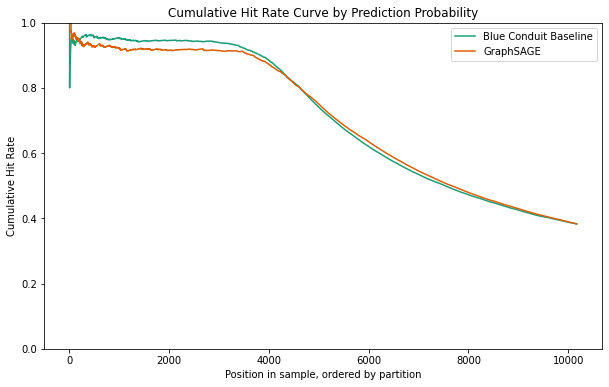

In [ ]:
train_size = 0.6
hex_size = 22
s = 1

test_y_pred_test_graphSAGE = final_test_preds[f'ts_{train_size}'][f'res_{hex_size}'][s]

data = select_data(Xdata,Ydata, pid, train_idx, test_idx, train_pred_all, test_pred_all, partitions_builder, train_size=train_size, n_hexagons=hex_size, split=s)
train_index = data['train_index']
test_index = data['test_index']
Xtrain = data['Xtrain']
Xtest = data['Xtest']
Ytrain = data['Ytrain']
Ytest = data['Ytest']
train_pred = data['train_pred']
test_pred = data['test_pred']
hexagons = data['hexagons']

#y_pred_test_graphSAGE = GraphSAGE_test_preds[f'ts_{train_size}'][f'res_{hex_size}'][s]
mod_train_list = [test_pred, test_y_pred_test_graphSAGE]

threshold_orig = 0.9
plot_hit_rate_curve(Ytest, mod_train_list, plot_probs=False, labels=['Blue Conduit Baseline', 'GraphSAGE'], mode='partition', 
                    parcel_df=hexagons.parcel_gdf, index_list=test_index, threshold_init=threshold_orig)


# DONE

# SPARE WORK:

# Scale the data

In [ ]:
# scaler = StandardScaler()
# Xdata_scaled_train = scaler.fit_transform(Xdata.iloc[train_index])
# Xdata_scaled_test = scaler.transform(Xdata.iloc[test_index])

# Xdata_scaled = Xdata.copy()
# Xdata_scaled.iloc[train_index] = Xdata_scaled_train
# Xdata_scaled.iloc[test_index] = Xdata_scaled_test
# Xdata_scaled

,Homestead Percent,HomeSEV,Land Value,Land Improvements Value,Residential Building Value,Commercial Building Value,Parcel Acres,Year Built,SL_Lead,Ed_July,Ed_March,Max_Lead,Med_Lead,Num_Tests,Res_Test,Sen_Test,B_median_age_all_women,B_median_age_all_men,B_median_age_all,B_median_age_all_women_white,B_median_age_all_men_white,B_median_age_all_white,B_median_age_all_women_black,B_median_age_all_men_black,B_median_age_all_black,B_total_black_pop,B_total_white_pop,B_married_couples,B_single_women,B_married_couples_white,B_single_women_white,B_married_couples_black,B_single_women_black,B_married_couples_w_children,B_single_mothers_w_children,B_households_w_elderly,B_househod_no_elderly,B_aggregate_income,B_speak_spanish,B_speak_only_english,...,CENTRACT_600,CENTRACT_700,CENTRACT_800,CENTRACT_900,CENTRACT_1000,CENTRACT_1100,CENTRACT_1200,CENTRACT_1300,CENTRACT_1400,CENTRACT_1500,CENTRACT_1600,CENTRACT_1700,CENTRACT_1800,CENTRACT_1900,CENTRACT_2000,CENTRACT_2200,CENTRACT_2300,CENTRACT_2400,CENTRACT_2600,CENTRACT_2700,CENTRACT_2800,CENTRACT_2900,CENTRACT_3000,CENTRACT_3100,CENTRACT_3200,CENTRACT_3300,CENTRACT_3400,CENTRACT_3500,CENTRACT_3600,CENTRACT_3700,CENTRACT_3800,CENTRACT_4000,CENTRACT_13500,CENTRACT_13600,CENBLOCK_1,CENBLOCK_2,CENBLOCK_3,CENBLOCK_4,CENBLOCK_5,CENBLOCK_6
0,0.398553,1.224099,-0.554546,-0.132839,-0.290141,-0.043008,-0.023841,-3.800170,-0.272755,-0.080081,-0.080081,-0.039726,-0.779736,-0.350296,-0.781104,-0.168513,-1.324648,-0.296246,-1.098771,0.232692,0.224647,-0.256367,-0.302082,0.668977,-0.585932,1.447928,-0.025916,0.01459,-0.200298,-0.952371,-0.979791,1.855925,0.695882,-0.389675,0.300235,-0.763148,1.389521,-0.207591,1.707996,1.321813,...,-0.035722,-0.252417,-0.101491,0.0,-0.090206,-0.167175,-0.221404,-0.197066,-0.167175,0.0,-0.226632,-0.065316,0.0,0.0,-0.121059,0.0,-0.201673,-0.128092,-0.165828,-0.139603,11.392005,-0.219284,-0.426294,-0.092569,-0.206193,0.0,0.0,-0.222457,-0.307205,-0.142733,-0.191175,-0.180156,-0.267322,0.0,-0.563941,1.395057,-0.543638,-0.42281,-0.202811,0.0
1,0.398553,0.507317,-0.599385,-0.132839,-0.560610,-0.043008,-1.101734,-3.800170,-0.272755,-0.080081,-0.080081,-0.039726,-0.779736,-0.350296,-0.781104,-0.168513,-1.324648,-0.296246,-1.098771,0.232692,0.224647,-0.256367,-0.302082,0.668977,-0.585932,1.447928,-0.025916,0.01459,-0.200298,-0.952371,-0.979791,1.855925,0.695882,-0.389675,0.300235,-0.763148,1.389521,-0.207591,1.707996,1.321813,...,-0.035722,-0.252417,-0.101491,0.0,-0.090206,-0.167175,-0.221404,-0.197066,-0.167175,0.0,-0.226632,-0.065316,0.0,0.0,-0.121059,0.0,-0.201673,-0.128092,-0.165828,-0.139603,11.392005,-0.219284,-0.426294,-0.092569,-0.206193,0.0,0.0,-0.222457,-0.307205,-0.142733,-0.191175,-0.180156,-0.267322,0.0,-0.563941,1.395057,-0.543638,-0.42281,-0.202811,0.0
2,-2.540192,-0.774203,-0.583446,-0.132839,-0.668811,-0.043008,-1.089758,0.199707,-0.272755,-0.080081,-0.080081,-0.039726,-0.779736,-0.350296,-0.781104,-0.168513,-1.324648,-0.296246,-1.098771,0.232692,0.224647,-0.256367,-0.302082,0.668977,-0.585932,1.447928,-0.025916,0.01459,-0.200298,-0.952371,-0.979791,1.855925,0.695882,-0.389675,0.300235,-0.763148,1.389521,-0.207591,1.707996,1.321813,...,-0.035722,-0.252417,-0.101491,0.0,-0.090206,-0.167175,-0.221404,-0.197066,-0.167175,0.0,-0.226632,-0.065316,0.0,0.0,-0.121059,0.0,-0.201673,-0.128092,-0.165828,-0.139603,11.392005,-0.219284,-0.426294,-0.092569,-0.206193,0.0,0.0,-0.222457,-0.307205,-0.142733,-0.191175,-0.180156,-0.267322,0.0,-0.563941,1.395057,-0.543638,-0.42281,-0.202811,0.0
3,-1.070820,-0.280058,-0.567770,-0.132839,-0.684418,-0.043008,-0.670577,-3.800170,-0.272755,-0.080081,-0.080081,-0.036121,1.255974,0.078512,1.280240,-0.168513,-1.324648,-0.296246,-1.098771,0.232692,0.224647,-0.256367,-0.302082,0.668977,-0.585932,1.447928,-0.025916,0.01459,-0.200298,-0.952371,-0.979791,1.855925,0.695882,-0.389675,0.300235,-0.763148,1.389521,-0.207591,1.707996,1.321813,...,-0.035722,-0.252417,-0.101491,0.0,-0.090206,-0.167175,-0.221404,-0.197066,-0.167175,0.0,-0.226632,-0.065316,0.

# data loaded

# build subgraph

In [ ]:
# #n_subgraph = 2000
# subgraph_idx = np.array([i for i in range(len(Ydata)) if (i in train_index or i in test_index)])
# n_subgraph = len(subgraph_idx)
# subgraph = graph[:,subgraph_idx][subgraph_idx,:]
# print('subgraph', subgraph.shape, '\n', subgraph)

subgraph (21647, 21647) 
 [[0.         0.02096436 0.02087683 ... 0.         0.         0.        ]
 [0.02710027 0.         0.01398601 ... 0.         0.         0.        ]
 [0.02242152 0.01344086 0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.03508772 0.02506266]
 [0.         0.         0.         ... 0.03968254 0.         0.03215434]
 [0.         0.         0.         ... 0.02314815 0.03215434 0.        ]]


# NOTE FROM GRAPHSAGE PAPER
# HELPS TO CUTOFF THE MAX NUM OF EDGES A NODE CAN HAVE
# THEY CUT IT OFF AT 128
# this is taken into account by GraphSAGE sampling neighbors so not too many neighbors are aggregated

# load graph nodes & edges matrices

In [ ]:
# train_mask = np.array([1 if i in train_index else 0 for i in range(len(Ydata))])
# test_mask = np.array([1 if i in test_index else 0 for i in range(len(Ydata))])

# def get_xgboost_prob(idx):
#   # idx: the index according to the original 0,...,26856 list
#   res = None
#   if train_mask[idx]:
#     res =  train_pred[np.where(train_index==idx)][0]
#   elif test_mask[idx]:
#     res = test_pred[np.where(test_index==idx)][0]
#   return res

# def get_label(idx):
#   # idx: the index according to the original 0,...,26856 list
#   return Ydata.dangerous.values[idx]
    
# def build_feature_matrix(features = None):
#   #'features' is a list of named features for use in feature matrix. Example: ['Year Built', 'Land Value', 'Lot Size']
#   #Set 'features' to 'All' to get full feature set
#   #Leave features as 'None' to just use XGBoost probabilities

#   #If no additional features, just use XGBoost probabilities
#   if features is None:
#     return np.array([[get_xgboost_prob(idx)] for idx in subgraph_idx])

#   #Append all features
#   elif features == 'All':
#     return np.hstack([np.array([get_xgboost_prob(idx) for idx in subgraph_idx]).reshape(-1,1), Xdata_scaled.iloc[subgraph_idx].values])

#   #Append selected features
#   else:
#     return np.hstack([np.array([get_xgboost_prob(idx) for idx in subgraph_idx]).reshape(-1,1), Xdata_scaled[features].iloc[subgraph_idx].values])

# train_indices = np.array([idx for idx in subgraph_idx if train_mask[idx]]).astype('int32')
# train_labels = np.array([get_label(idx) for idx in subgraph_idx if train_mask[idx]])
# test_indices = np.array([idx for idx in subgraph_idx if test_mask[idx]]).astype('int32')
# test_labels = np.array([get_label(idx) for idx in subgraph_idx if test_mask[idx]])

# #chosen_features = ['Year Built', 'Land Value', 'Parcel Acres', 'Residential Building Value', 'Hydrant Type_A.D.', 'Hydrant Type_Dar', 'Hydrant Type_Mueller', 'Hydrant Type_Other','Hydrant Type_T.C.']
# chosen_features = Xdata.columns
# fts = build_feature_matrix(features='All').astype('float32')

# sparse_subgraph = csr_matrix(subgraph)
# row_idx, col_idx, vals = scipy.sparse.find(sparse_subgraph)

# # Define graph, namely an edge tensor and a node feature tensor
# edges = np.vstack([subgraph_idx[col_idx], subgraph_idx[row_idx]]).T.astype('float32')

# print(fts.shape, train_indices.shape, train_labels.shape, test_indices.shape, test_labels.shape, edges.shape)

(21647, 302) (2354,) (2354,) (19293,) (19293,) (8016368, 2)


# prepare StellarGraph data

In [ ]:
# flint_train_labels_series = pd.Series(data=train_labels,index=train_indices)
# flint_test_labels_series = pd.Series(data=test_labels,index=test_indices)

# flint_features = np.append(['XGBoost Prob'], chosen_features)
# flint_node_data = pd.DataFrame(
#     {f : fts[:,i] for i, f in enumerate(flint_features)}, index=subgraph_idx.astype('int64')
# )
# flint_edge_data = pd.DataFrame({"source": edges[:,0].astype('int64'), "target": edges[:,1].astype('int64')})
# flint_G = sg.StellarGraph(flint_node_data, flint_edge_data)
# print(flint_G.info())

StellarGraph: Undirected multigraph
 Nodes: 21647, Edges: 8016368

 Node types:
  default: [21647]
    Features: float32 vector, length 302
    Edge types: default-default->default

 Edge types:
    default-default->default: [8016368]
        Weights: all 1 (default)
        Features: none


# trying GraphSAGE

In [ ]:
# target_encoding = preprocessing.LabelBinarizer()
# train_targets = target_encoding.fit_transform(flint_train_labels_series)
# test_targets = target_encoding.transform(flint_test_labels_series)

# batch_size = 256
# num_samples = [15, 10]
# generator = GraphSAGENodeGenerator(flint_G, batch_size, num_samples)

# flint_graphSAGE_train_gen = generator.flow(flint_train_labels_series.index, train_targets)
# flint_graphSAGE_test_gen = generator.flow(flint_test_labels_series.index, test_targets)

# graphsage_model = GraphSAGE(
#   layer_sizes=[64, 64], generator=generator, bias=True, dropout=0.5,
# )

# x_inp, x_out = graphsage_model.in_out_tensors()
# prediction = layers.Dense(units=train_targets.shape[1], activation="sigmoid")(x_out)

# flint_graphSAGE = Model(inputs=x_inp, outputs=prediction)

In [ ]:
# flint_graphSAGE.compile(
#       optimizer=tf.keras.optimizers.Adam(learning_rate=1e-2),
#       loss=tf.keras.losses.BinaryCrossentropy(),
#       metrics=[tf.keras.metrics.BinaryAccuracy(name='acc'), tf.keras.metrics.Precision(name='prec'), tf.keras.metrics.Recall(name='rec'), tf.keras.metrics.TruePositives(name='tp'), tf.keras.metrics.TrueNegatives(name='tn'), tf.keras.metrics.FalsePositives(name='fp'), tf.keras.metrics.FalseNegatives(name='fn') ]
#   )
# flint_graphSAGE.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 15, 302)]    0                                            
__________________________________________________________________________________________________
input_9 (InputLayer)            [(None, 150, 302)]   0                                            
__________________________________________________________________________________________________
input_7 (InputLayer)            [(None, 1, 302)]     0                                            
__________________________________________________________________________________________________
reshape_8 (Reshape)             (None, 1, 15, 302)   0           input_8[0][0]                    
____________________________________________________________________________________________

Epoch 1/100
10/10 - 4s - loss: 0.6977 - acc: 0.5208 - prec: 0.4413 - rec: 0.5544 - tp: 545.0000 - tn: 681.0000 - fp: 690.0000 - fn: 438.0000
Epoch 2/100
10/10 - 2s - loss: 0.5153 - acc: 0.7804 - prec: 0.8447 - rec: 0.5809 - tp: 571.0000 - tn: 1266.0000 - fp: 105.0000 - fn: 412.0000
Epoch 3/100
10/10 - 2s - loss: 0.4045 - acc: 0.8513 - prec: 0.8070 - rec: 0.8464 - tp: 832.0000 - tn: 1172.0000 - fp: 199.0000 - fn: 151.0000
Epoch 4/100
10/10 - 2s - loss: 0.3597 - acc: 0.8632 - prec: 0.8145 - rec: 0.8708 - tp: 856.0000 - tn: 1176.0000 - fp: 195.0000 - fn: 127.0000
Epoch 5/100
10/10 - 2s - loss: 0.3248 - acc: 0.8798 - prec: 0.8405 - rec: 0.8789 - tp: 864.0000 - tn: 1207.0000 - fp: 164.0000 - fn: 119.0000
Epoch 6/100
10/10 - 2s - loss: 0.3067 - acc: 0.8904 - prec: 0.8673 - rec: 0.8708 - tp: 856.0000 - tn: 1240.0000 - fp: 131.0000 - fn: 127.0000
Epoch 7/100
10/10 - 2s - loss: 0.2761 - acc: 0.9019 - prec: 0.8672 - rec: 0.9034 - tp: 888.0000 - tn: 1235.0000 - fp: 136.0000 - fn: 95.0000
Epoch 8/

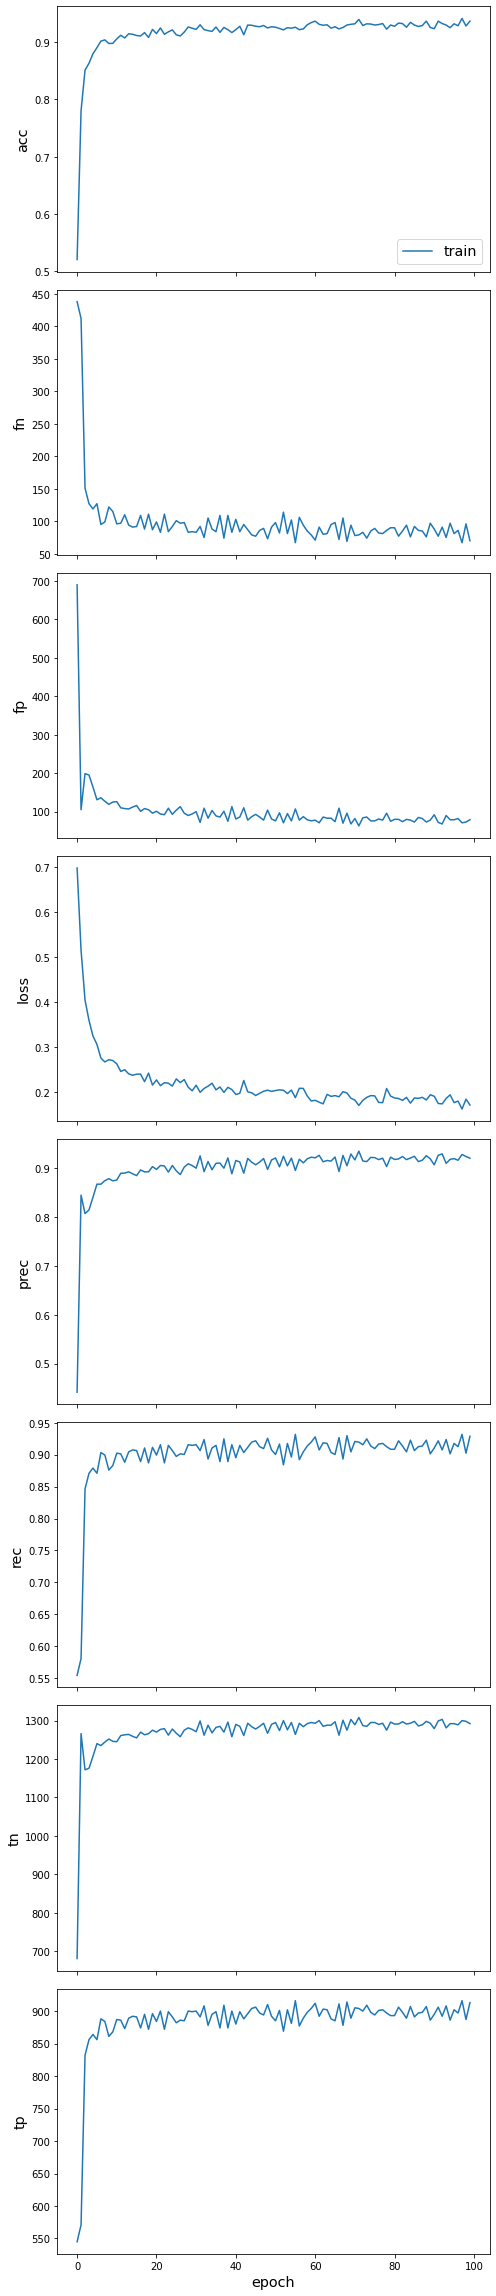

In [ ]:
# flint_graphSAGE_history = flint_graphSAGE.fit(
#     flint_graphSAGE_train_gen,
#     epochs=100,
#     verbose=2,
#     shuffle=True,
# )
# #flint_graphSAGE_embedding_model = Model(inputs=x_inp, outputs=x_out)
# sg.utils.plot_history(flint_graphSAGE_history)

In [ ]:
y_pred_train_graphSAGE = flint_graphSAGE.predict(flint_graphSAGE_train_gen).flatten()
y_pred_test_graphSAGE = flint_graphSAGE.predict(flint_graphSAGE_test_gen).flatten()

In [ ]:
# mod_train_list = [test_pred, y_pred_test_graphSAGE]

# # threshold_orig = 0.9
# # plot_hit_rate_curve(Ytest, mod_train_list, plot_probs=False, labels=['Blue Conduit Baseline', 'GraphSAGE'], mode='partition', 
# #                     parcel_df=hexagons.parcel_gdf, index_list=test_index, threshold_init=threshold_orig)
# threshold_init = 0.96
# threshold_delta = .04
# hrc_xgboost, pred_probs_xgboost = generate_hit_rate_curve_by_partition(hexagons.parcel_gdf, test_index, Ytest, test_pred, threshold_init, threshold_increment=threshold_delta)
# hrc_graphsage, pred_probs_graphsage = generate_hit_rate_curve_by_partition(hexagons.parcel_gdf, test_index, Ytest, y_pred_test_graphSAGE, threshold_init, threshold_increment=threshold_delta)


/usr/local/lib/python3.7/dist-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


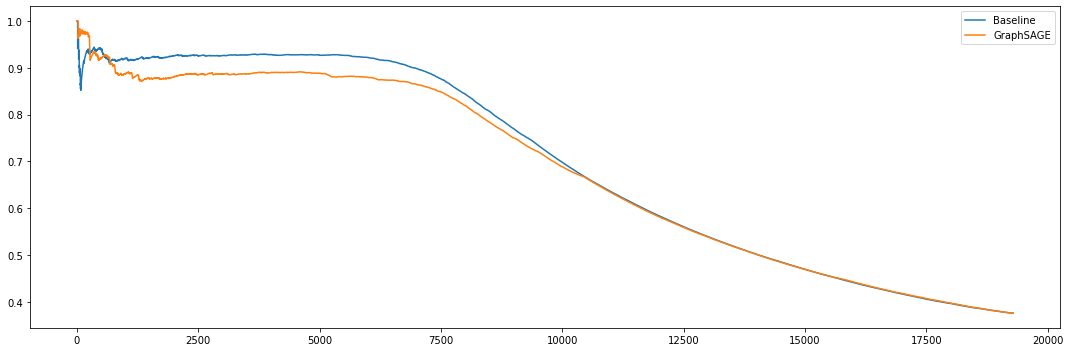

In [ ]:
# fig, ax = plt.subplots(figsize=(15,5))
# ax.plot(np.arange(len(Ytest)), hrc_xgboost, label='Baseline')
# ax.plot(np.arange(len(Ytest)), hrc_graphsage, label='GraphSAGE')
# ax.legend()
# plt.tight_layout()
# plt.show()

In [ ]:
# def eval_tptnfpfn(Ytest, y_pred):
#   tp = sum((np.round(y_pred)==Ytest).astype(int)*(Ytest==1.0).astype(int))
#   tn = sum((np.round(y_pred)==Ytest).astype(int)*(Ytest==0.0).astype(int))

#   fn = sum((np.round(y_pred)!=Ytest).astype(int)*(Ytest==1.0).astype(int))
#   fp = sum((np.round(y_pred)!=Ytest).astype(int)*(Ytest==0.0).astype(int))
#   return tp, tn, fp, fn
# scores_graphSAGE = eval_tptnfpfn(Ytest, y_pred_test_graphSAGE)
# scores_xgboost = eval_tptnfpfn(Ytest, test_pred)
# metrics = ['tp', 'tn', 'fp', 'fn']
# for i in range(4):
#   print(metrics[i])
#   print('\t', 'XGBoost: ', scores_xgboost[i])
#   print('\t', 'GraphSAGE: ', scores_graphSAGE[i])
# print("TP")
# print(scores_graphSAGE)
# print(scores_xgboost)

tp
	 XGBoost:  6570
	 GraphSAGE:  6450
tn
	 XGBoost:  11124
	 GraphSAGE:  10796
fp
	 XGBoost:  925
	 GraphSAGE:  1253
fn
	 XGBoost:  674
	 GraphSAGE:  794
TP
(6450, 10796, 1253, 794)
(6570, 11124, 925, 674)


In [ ]:
# def compare_pred_to_jared(y_pred):
#     fig, axes = plt.subplots(1, 2, figsize=(12,6))

#     jared_right_indices = np.array([i for i in range(len(Ytest)) if Ytest[i]==np.round(test_pred[i]).astype(int)])
#     jared_wrong_indices = np.array([i for i in range(len(Ytest)) if Ytest[i]!=np.round(test_pred[i]).astype(int)])

#     axes[0].scatter(test_pred[jared_right_indices], y_pred[jared_right_indices], marker='o', label='Baseline XGBoost correct', alpha=0.1)
#     axes[1].scatter(test_pred[jared_wrong_indices], y_pred[jared_wrong_indices], marker='x', s=100, label='Baseline XGBoost incorrect', alpha=0.1)
#     axes[0].set_xlabel('Baseline XGBoost model prediction')
#     axes[0].set_ylabel('Spatial model prediction')
#     axes[0].set_title(f'Comparing XGBoost & Spatial Model\n # XGBoost correct: {len(jared_right_indices)}')
#     axes[1].set_xlabel('Baseline XGBoost model prediction')
#     axes[1].set_ylabel('Spatial model prediction')
#     axes[1].set_title(f'Comparing XGBoost & Spatial Model\n # XGBoost incorrect: {len(jared_wrong_indices)}')
#     axes[0].legend()
#     axes[1].legend()
#     plt.show()

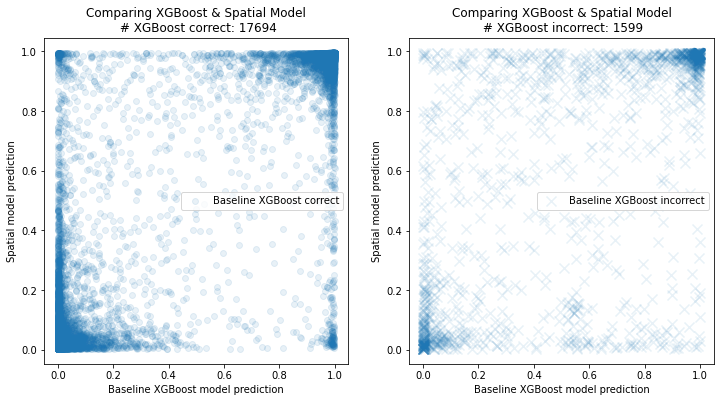

In [ ]:
# compare_pred_to_jared(y_pred_test_graphSAGE)

# save graphSAGE predictions to google drive

In [ ]:
# with open(pred_dir+'/y_pred_train_graphSAGE.npy', 'wb') as f:
#   np.save(f, y_pred_train_graphSAGE)
# with open(pred_dir+'/y_pred_test_graphSAGE.npy', 'wb') as f:
#   np.save(f, y_pred_test_graphSAGE)

In [ ]:
# np.load(pred_dir+'/y_pred_graphSAGE.npy')

array([0.9854183 , 0.9891689 , 0.98404217, ..., 0.00306793, 0.00279974,
       0.00289665], dtype=float32)

In [ ]:
def plot_embeddings(embedding_model, gen, label_series):

  from sklearn.manifold import TSNE

  X = embedding_model.predict(gen)
  y = np.argmax(target_encoding.transform(label_series), axis=1)

  trans = TSNE(n_components=2)
  emb_transformed = pd.DataFrame(trans.fit_transform(X), index=label_series.index)
  emb_transformed["label"] = y

  alpha = 0.7

  fig, ax = plt.subplots(figsize=(7, 7))
  ax.scatter(
      emb_transformed[0],
      emb_transformed[1],
      c=emb_transformed["label"].astype("category"),
      cmap="jet",
      alpha=alpha,
  )
  ax.set(aspect="equal", xlabel="$X_1$", ylabel="$X_2$")

  plt.show()
# plot_embeddings(flint_graphSAGE_embedding_model, flint_graphSAGE_test_gen, flint_test_labels_series)

# define GAT

In [ ]:
def get_GAT_model(G, train_labels, test_labels):

  target_encoding = preprocessing.LabelBinarizer()

  train_targets = target_encoding.fit_transform(train_labels)
  # if train_targets.shape[1]==1:
  #   train_targets = np.column_stack([1 - train_targets, train_targets])

  test_targets = target_encoding.transform(test_labels)
  # if test_targets.shape[1]==1:
  #   test_targets = np.column_stack([1 - test_targets, test_targets])

  generator = FullBatchNodeGenerator(G, method="gat")

  train_gen = generator.flow(train_labels.index, train_targets)
  test_gen = generator.flow(test_labels.index, test_targets)

  gat = GAT(
      layer_sizes=[8, train_targets.shape[1]],
      activations=["elu", "sigmoid"],
      attn_heads=8,
      generator=generator,
      in_dropout=0.5,
      attn_dropout=0.5,
      normalize=None,
  )

  x_inp, predictions = gat.in_out_tensors()

  model = Model(inputs=x_inp, outputs=predictions)

  return model, train_gen, test_gen


In [ ]:
# flint_GAT_model, flint_GAT_train_gen, flint_GAT_test_gen = get_GAT_model(flint_G, flint_train_labels_series, flint_test_labels_series)
# flint_GAT_model.compile(
#       optimizer=tf.keras.optimizers.Adam(learning_rate=1e-2),
#       loss=tf.keras.losses.binary_crossentropy,
#       metrics=[tf.keras.metrics.BinaryAccuracy(name='acc'), tf.keras.metrics.Precision(name='prec'), tf.keras.metrics.Recall(name='rec'), tf.keras.metrics.TruePositives(name='tp'), tf.keras.metrics.TrueNegatives(name='tn'), tf.keras.metrics.FalsePositives(name='fp'), tf.keras.metrics.FalseNegatives(name='fn') ]
#   )
# flint_GAT_model.summary()

Epoch 1/100
1/1 - 11s - loss: 2.7359 - acc: 0.5251 - prec: 0.4241 - rec: 0.3835 - tp: 377.0000 - tn: 859.0000 - fp: 512.0000 - fn: 606.0000
Epoch 2/100
1/1 - 8s - loss: 2.2267 - acc: 0.5225 - prec: 0.4525 - rec: 0.6836 - tp: 672.0000 - tn: 558.0000 - fp: 813.0000 - fn: 311.0000
Epoch 3/100
1/1 - 8s - loss: 1.6785 - acc: 0.5875 - prec: 0.5043 - rec: 0.7233 - tp: 711.0000 - tn: 672.0000 - fp: 699.0000 - fn: 272.0000
Epoch 4/100
1/1 - 7s - loss: 1.3827 - acc: 0.6308 - prec: 0.5359 - rec: 0.8647 - tp: 850.0000 - tn: 635.0000 - fp: 736.0000 - fn: 133.0000
Epoch 5/100
1/1 - 8s - loss: 1.2781 - acc: 0.6364 - prec: 0.5462 - rec: 0.7630 - tp: 750.0000 - tn: 748.0000 - fp: 623.0000 - fn: 233.0000
Epoch 6/100
1/1 - 7s - loss: 1.0747 - acc: 0.7362 - prec: 0.6893 - rec: 0.6704 - tp: 659.0000 - tn: 1074.0000 - fp: 297.0000 - fn: 324.0000
Epoch 7/100
1/1 - 7s - loss: 0.7416 - acc: 0.7782 - prec: 0.7307 - rec: 0.7426 - tp: 730.0000 - tn: 1102.0000 - fp: 269.0000 - fn: 253.0000
Epoch 8/100
1/1 - 8s - l

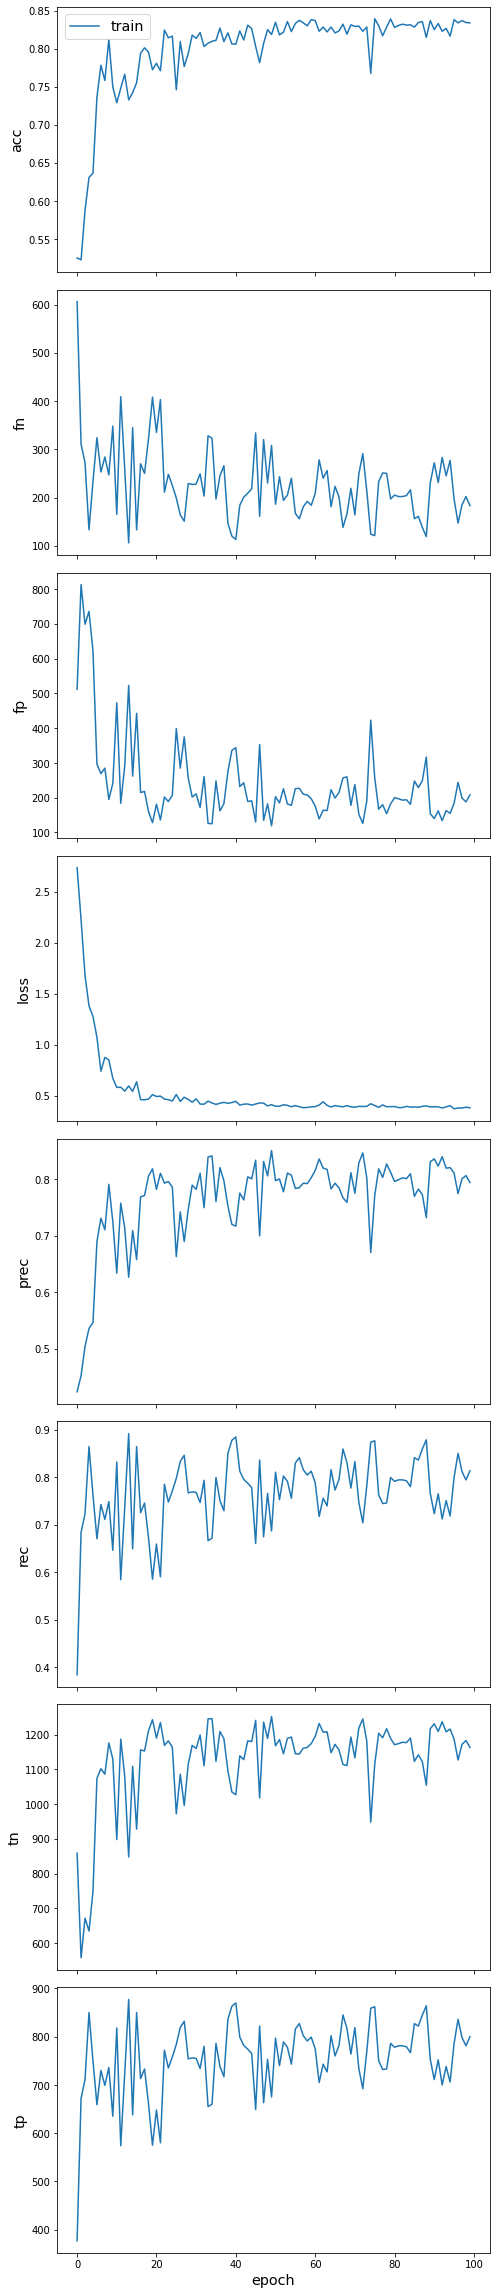

In [ ]:
# flint_GAT_history = flint_GAT_model.fit(
#     flint_train_gen,
#     epochs=100,
#     verbose=2,
#     shuffle=False,  # this should be False, since shuffling data means shuffling the whole graph
# )
# sg.utils.plot_history(flint_GAT_history)

/usr/local/lib/python3.7/dist-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/usr/local/lib/python3.7/dist-packages/blue_conduit_spatial/evaluation/evaluate.py:131: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['dig'] = (df['pred_prob'] > threshold).astype(int)


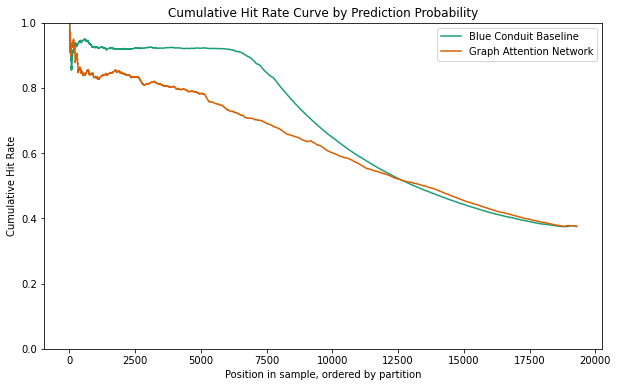

In [ ]:
# y_pred_GAT = flint_GAT_model.predict(flint_GAT_test_gen)[0].flatten()#flint_model.predict(flint_test_gen)[0,:,1]
# mod_train_list = [test_pred, y_pred_GAT]

# threshold_orig = 0.9

# plot_hit_rate_curve(Ytest, mod_train_list, plot_probs=False, labels=['Blue Conduit Baseline', 'Graph Attention Network'], mode='partition', 
#                     parcel_df=hexagons.parcel_gdf, index_list=test_index, threshold_init=threshold_orig)


In [ ]:
# compare_pred_to_jared(y_pred_GAT)